#Big Data in Global Health Statistics
By Zijian Zhang, Dec 15th, 2022

# Introduction

During the pandemic of COVID-19, the importance of health data science has drawn wide attention around the world. We would love to acquire some insights of the global health situation by investigating the health statistics data (HealthStats) around the world.

HealthStats provides key health, nutrition and population statistics gathered from a variety of international sources. Themes include population dynamics, nutrition, reproductive health, health financing, medical resources and usage, immunization, infectious diseases, HIV/AIDS, DALY, population projections and lending. HealthStats also includes health, nutrition and population statistics by wealth quintiles.

The [dataset](https://www.kaggle.com/datasets/theworldbank/health-nutrition-and-population-statistics) we use in our project is the global health statistics dataset from World Bank, containing more than 340 indicators across more than 250 countries or regions around the world.

**Our ultimate goal for this project is to predict the global life expectancy at birth using multiple models, including linear regression, logistic regression, neural networks, decision tree, and random forest.**

**In addition to this, we also applied KNN for value imputation, cross-validation for hyperparameter tuning, K-means for clustering in EDA, PCA for preprocessing, and so on.**

**In the end, we derived a novel model using ARIMA to get the predicted features, and then fit into the trained models to get final prediction for future global life expectancy.**

# Enviroment Setup

In [ ]:
!pip3 install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.2 MB/s 
     |████████████████████████████████| 9.9 MB 15.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
# Setup
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive

# Sklearn Setup
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, Lasso, LinearRegression, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import plotly.express as px

from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!apt update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,568 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://se

# Data Loading and Preprocessing

## Read data

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Create the kaggle directory and read the uploaded kaggle.json file
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

To get `kaggle.json` in here:
1. Go to this [Kaggle link](https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata) and create a Kaggle account (unless you already have an account)
2. Go to Account and click on "Create New API Token" to get the API key in the form of a json file `kaggle.json`
3. Upload the `kaggle.json` file to the default location in your Google Drive 

In [ ]:
# Please upload the kaggle.json file to the root folder of the Google Drive
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!!kaggle datasets download -d theworldbank/health-nutrition-and-population-statistics

['Downloading health-nutrition-and-population-statistics.zip to /content',
 '',
 '  0% 0.00/14.0M [00:00<?, ?B/s]',
 ' 64% 9.00M/14.0M [00:00<00:00, 78.4MB/s]',
 '',
 '100% 14.0M/14.0M [00:00<00:00, 105MB/s] ']

In [ ]:
# Unzip folder in Colab content folder
!unzip /content/health-nutrition-and-population-statistics.zip

Archive:  /content/health-nutrition-and-population-statistics.zip
  inflating: data.csv                


Read the csv file into a dataframe called `df_health_population_stats`. Let's take a look at what the data looks like.

In [ ]:
# TO-DO: Read the csv file and save it to a dataframe called `df_health_population_stats`
df_health_population_stats = pd.read_csv("data.csv")

# Check out the first five rows
df_health_population_stats.head(5)

Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   
3   Arab World          ARB   
4   Arab World          ARB   

                                      Indicator Name     Indicator Code  \
0  % of females ages 15-49 having comprehensive c...  SH.HIV.KNOW.FE.ZS   
1  % of males ages 15-49 having comprehensive cor...  SH.HIV.KNOW.MA.ZS   
2  Adolescent fertility rate (births per 1,000 wo...        SP.ADO.TFRT   
3  Adults (ages 15+) and children (0-14 years) li...        SH.HIV.TOTL   
4  Adults (ages 15+) and children (ages 0-14) new...     SH.HIV.INCD.TL   

         1960        1961        1962        1963        1964        1965  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2  133.555013  134.159119  134.857912  134.504576  134.105211  133.569626   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   ...       2007       2008       2009       2010       2011       2012  \
0  ...        NaN        NaN        NaN        NaN        NaN        NaN   
1  ...        NaN        NaN        NaN        NaN        NaN        NaN   
2  ...  49.999851  49.887046  49.781207  49.672975  49.536047  49.383745   
3  ...        NaN        NaN        NaN        NaN        NaN        NaN   
4  ...        NaN        NaN        NaN        NaN        NaN        NaN   

        2013       2014  2015  Unnamed: 60  
0        NaN        NaN   NaN          NaN  
1        NaN        NaN   NaN          NaN  
2  48.796558  48.196418   NaN          NaN  
3        NaN        NaN   NaN          NaN  
4        NaN        NaN   NaN          NaN  

[5 rows x 61 columns]

We could that there are lots of `NaN` in the dataframe. This is due to the missing data for speific conutries and regions for some indicators.

## Preprocess Data

After the initial observation, we found that the last column of the initial csv file contains nothing. So we decide to drop this column first.

In [ ]:
df_health_population_stats = df_health_population_stats.drop(columns=['Unnamed: 60'])
df_health_population_stats

Country Name Country Code  \
0       Arab World          ARB   
1       Arab World          ARB   
2       Arab World          ARB   
3       Arab World          ARB   
4       Arab World          ARB   
...            ...          ...   
89005     Zimbabwe          ZWE   
89006     Zimbabwe          ZWE   
89007     Zimbabwe          ZWE   
89008     Zimbabwe          ZWE   
89009     Zimbabwe          ZWE   

                                          Indicator Name     Indicator Code  \
0      % of females ages 15-49 having comprehensive c...  SH.HIV.KNOW.FE.ZS   
1      % of males ages 15-49 having comprehensive cor...  SH.HIV.KNOW.MA.ZS   
2      Adolescent fertility rate (births per 1,000 wo...        SP.ADO.TFRT   
3      Adults (ages 15+) and children (0-14 years) li...        SH.HIV.TOTL   
4      Adults (ages 15+) and children (ages 0-14) new...     SH.HIV.INCD.TL   
...                                                  ...                ...   
89005  Use of insecticide-treated bed nets (% of unde...     SH.MLR.NETS.ZS   
89006  Use of Intermittent Preventive Treatment of ma...     SH.MLR.SPF2.ZS   
89007  Vitamin A supplementation coverage rate (% of ...     SN.ITK.VITA.ZS   
89008           Wanted fertility rate (births per woman)        SP.DYN.WFRT   
89009  Women's share of population ages 15+ living wi...  SH.DYN.AIDS.FE.ZS   

             1960        1961        1962        1963        1964        1965  \
0             NaN         NaN         NaN         NaN         NaN         NaN   
1             NaN         NaN         NaN         NaN         NaN         NaN   
2      133.555013  134.159119  134.857912  134.504576  134.105211  133.569626   
3             NaN         NaN         NaN         NaN         NaN         NaN   
4             NaN         NaN         NaN         NaN         NaN         NaN   
...           ...         ...         ...         ...         ...         ...   
89005         NaN         NaN         NaN         NaN         NaN         NaN   
89006         NaN         NaN         NaN         NaN         NaN         NaN   
89007         NaN         NaN         NaN         NaN         NaN         NaN   
89008         NaN         NaN         NaN         NaN         NaN         NaN   
89009         NaN         NaN         NaN         NaN         NaN         NaN   

       ...       2006       2007       2008       2009       2010       2011  \
0      ...        NaN        NaN        NaN        NaN        NaN        NaN   
1      ...        NaN        NaN        NaN        NaN        NaN        NaN   
2      ...  50.329135  49.999851  49.887046  49.781207  49.672975  49.536047   
3      ...        NaN        NaN        NaN        NaN        NaN        NaN   
4      ...        NaN        NaN        NaN        NaN        NaN        NaN   
...    ...        ...        ...        ...        ...        ...        ...   
89005  ...   3.100000        NaN        NaN  17.300000        NaN   9.700000   
89006  ...   6.300000        NaN        NaN  13.900000        NaN   7.300000   
89007  ...  67.000000  83.000000   0.000000  77.000000  49.000000  47.000000   
89008  ...   3.300000        NaN        NaN        NaN        NaN   3.500000   
89009  ...  58.331272  58.586086  58.760796  58.812421  58.825943  58.899308   

            2012       2013       2014       2015  
0            NaN        NaN        NaN        NaN  
1            NaN        NaN        NaN        NaN  
2      49.383745  48.796558  48.196418        NaN  
3            NaN        NaN        NaN        NaN  
4            NaN        NaN        NaN        NaN  
...          ...        ...        ...        ...  
89005        NaN        NaN  26.800000        NaN  
89006        NaN        NaN  12.900000        NaN  
89007  61.000000  34.000000  32.000000        NaN  
89008        NaN        NaN        NaN        NaN  
89009  58.939080  58.900126  58.822335  58.855551  

[89010 rows x 60 columns]

### Check Nulls

Upon a closer observation, we found that there are missing data in lots of rows. And the main reason should be that there is no data provided for those indicators of the specific countries or regions. So we decided to drop the rows in `df_health_population_stats` which have greater than 50% Null Values.

The reason why we choose 50% as the threshold of dropping nulls is that we would love to balance between droping rows with too many rows and keeping more features.

In [ ]:
count = int(0.5 * df_health_population_stats.shape[1])
df_health_population_stats = df_health_population_stats.dropna(axis=0, thresh=count).reset_index(drop=True)
df_health_population_stats

Country Name Country Code  \
0       Arab World          ARB   
1       Arab World          ARB   
2       Arab World          ARB   
3       Arab World          ARB   
4       Arab World          ARB   
...            ...          ...   
43734     Zimbabwe          ZWE   
43735     Zimbabwe          ZWE   
43736     Zimbabwe          ZWE   
43737     Zimbabwe          ZWE   
43738     Zimbabwe          ZWE   

                                          Indicator Name     Indicator Code  \
0      Adolescent fertility rate (births per 1,000 wo...        SP.ADO.TFRT   
1      Age dependency ratio (% of working-age populat...        SP.POP.DPND   
2                              Age dependency ratio, old     SP.POP.DPND.OL   
3                            Age dependency ratio, young     SP.POP.DPND.YG   
4                   Birth rate, crude (per 1,000 people)     SP.DYN.CBRT.IN   
...                                                  ...                ...   
43734             Survival to age 65, male (% of cohort)  SP.DYN.TO65.MA.ZS   
43735                                   Urban population        SP.URB.TOTL   
43736                      Urban population (% of total)  SP.URB.TOTL.IN.ZS   
43737                 Urban population growth (annual %)        SP.URB.GROW   
43738  Women's share of population ages 15+ living wi...  SH.DYN.AIDS.FE.ZS   

                1960           1961           1962           1963  \
0         133.555013     134.159119     134.857912     134.504576   
1          87.799235      89.221714      90.502403      91.603014   
2           6.635328       6.746978       6.840980       6.915871   
3          81.024250      82.316142      83.459807      84.413972   
4          47.699716      47.457093      47.199572      46.919206   
...              ...            ...            ...            ...   
43734      43.355800      43.888050      44.420300      44.878710   
43735  473101.000000  497024.000000  524099.000000  562238.000000   
43736      12.608000      12.821000      13.082000      13.578000   
43737       4.897746       4.932942       5.304228       7.024465   
43738            NaN            NaN            NaN            NaN   

                1964           1965  ...          2006          2007  \
0         134.105211     133.569626  ...  5.032914e+01  4.999985e+01   
1          92.414916      92.868163  ...  6.578673e+01  6.463007e+01   
2           6.968155       6.996499  ...  6.821022e+00  6.765206e+00   
3          85.096657      85.470717  ...  5.735923e+01  5.616857e+01   
4          46.611790      46.270750  ...  2.727014e+01  2.728815e+01   
...              ...            ...  ...           ...           ...   
43734      45.337110      45.795520  ...  2.240553e+01  2.378692e+01   
43735  603076.000000  646516.000000  ...  4.453786e+06  4.487076e+06   
43736      14.092000      14.620000  ...  3.392600e+01  3.374300e+01   
43737       7.011798       6.955472  ...  5.584083e-01  7.446744e-01   
43738            NaN            NaN  ...  5.833127e+01  5.858609e+01   

               2008          2009          2010          2011          2012  \
0      4.988705e+01  4.978121e+01  4.967297e+01  4.953605e+01  4.938374e+01   
1      6.360263e+01  6.273802e+01  6.205350e+01  6.179494e+01  6.168190e+01   
2      6.712015e+00  6.672599e+00  6.653749e+00  6.678820e+00  6.715494e+00   
3      5.512340e+01  5.425597e+01  5.357864e+01  5.331823e+01  5.320907e+01   
4      2.732055e+01  2.737012e+01  2.742164e+01  2.739020e+01  2.728440e+01   
...             ...           ...           ...           ...           ...   
43734  2.722864e+01  3.067035e+01  3.411207e+01  3.755378e+01  4.099550e+01   
43735  4.529077e+06  4.579794e+06  4.638775e+06  4.706484e+06  4.782430e+06   
43736  3.356000e+01  3.337800e+01  3.319600e+01  3.301500e+01  3.283400e+01   
43737  9.316901e-01  1.113585e+00  1.279630e+00  1.449081e+00  1.600765e+00   
43738  5.876080e+01  5.881242e+01  5.882594e+01  5.889931e+01  5.893908e+

### Country Code and Country Name
We guess that the 'Country Name' column and the 'Country Code' column are on a one-to-one relationship. We drop the duplicates of the two columns and found that they have the same number of rows, which justify our guess that there is a one-to-one relationship between 'Country Name' column and the 'Country Code' column. In the `df_country_name_code`, we are storing the matching between the country names and country code.

In [ ]:
df_country_name_code =  df_health_population_stats[['Country Name', 'Country Code']].drop_duplicates().reset_index(drop = True)
df_country_name_code

Country Name Country Code
0                        Arab World          ARB
1            Caribbean small states          CSS
2    Central Europe and the Baltics          CEB
3        Early-demographic dividend          EAR
4               East Asia & Pacific          EAS
..                              ...          ...
253           Virgin Islands (U.S.)          VIR
254              West Bank and Gaza          WBG
255                     Yemen, Rep.          YEM
256                          Zambia          ZMB
257                        Zimbabwe          ZWE

[258 rows x 2 columns]

### Unique Country Names
Then we try to take a look at the unique values of the 'Country Name' column. We found out that the it contains specific countries as well as specific regions.

In [ ]:
df_health_population_stats['Country Name'].unique()

array(['Arab World', 'Caribbean small states',
       'Central Europe and the Baltics', 'Early-demographic dividend',
       'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'East Asia & Pacific (IDA & IBRD countries)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Europe & Central Asia (IDA & IBRD countries)', 'European Union',
       'Fragile and conflict affected situations',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'Late-demographic dividend', 'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle income',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Middle East & North Africa (IDA & IBRD c

### Indicator Name and Indicator Code
We also guess that the 'Indicagtor Code' column is the refined version of the 'Indicator Name' column. We look at the unique values in the two columns and justify the relationship. In the `df_indicator_name_code`, we are storing the matching between the indicator names and indicator code.

In [ ]:
df_indicator_name_code = df_health_population_stats[['Indicator Name', 'Indicator Code']].drop_duplicates().reset_index(drop = True)
df_indicator_name_code

Indicator Name     Indicator Code
0    Adolescent fertility rate (births per 1,000 wo...        SP.ADO.TFRT
1    Age dependency ratio (% of working-age populat...        SP.POP.DPND
2                            Age dependency ratio, old     SP.POP.DPND.OL
3                          Age dependency ratio, young     SP.POP.DPND.YG
4                 Birth rate, crude (per 1,000 people)     SP.DYN.CBRT.IN
..                                                 ...                ...
221  Population ages10-14, male (% of male population)  SP.POP.1014.MA.5Y
222                      Physicians (per 1,000 people)     SH.MED.PHYS.ZS
223                      Age at first marriage, female     SP.DYN.SMAM.FE
224                        Age at first marriage, male     SP.DYN.SMAM.MA
225  Urban poverty headcount ratio at national pove...        SI.POV.URHC

[226 rows x 2 columns]

### Unique Indicator Names
Now, we look at the unique values in the 'Indicator Name' column. It contains all the possible factors that we can do further analysis on.

In [ ]:
df_indicator_name_code['Indicator Name'].unique()

array(['Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Age dependency ratio (% of working-age population)',
       'Age dependency ratio, old', 'Age dependency ratio, young',
       'Birth rate, crude (per 1,000 people)',
       'Death rate, crude (per 1,000 people)', 'Female population 00-04',
       'Female population 05-09', 'Female population 10-14',
       'Female population 15-19', 'Female population 20-24',
       'Female population 25-29', 'Female population 30-34',
       'Female population 35-39', 'Female population 40-44',
       'Female population 45-49', 'Female population 50-54',
       'Female population 55-59', 'Female population 60-64',
       'Female population 65-69', 'Female population 70-74',
       'Female population 75-79', 'Female population 80+',
       'Fertility rate, total (births per woman)',
       'Immunization, BCG (% of one-year-old children)',
       'Immunization, DPT (% of children ages 12-23 months)',
       'Immunization, m

### Drop Indicator Code and Country Code
Since we have already stored the matchings for countries and indicators between names and codes, we can drop the two codes for simplicity.

In [ ]:
df_health_population_stats_clean = df_health_population_stats.drop(columns=['Country Code', 'Indicator Code'])
df_health_population_stats_clean = df_health_population_stats_clean.rename(columns={'Country Name': 'Country', 'Indicator Name': 'Indicator'})
df_health_population_stats_clean

Country                                          Indicator  \
0      Arab World  Adolescent fertility rate (births per 1,000 wo...   
1      Arab World  Age dependency ratio (% of working-age populat...   
2      Arab World                          Age dependency ratio, old   
3      Arab World                        Age dependency ratio, young   
4      Arab World               Birth rate, crude (per 1,000 people)   
...           ...                                                ...   
43734    Zimbabwe             Survival to age 65, male (% of cohort)   
43735    Zimbabwe                                   Urban population   
43736    Zimbabwe                      Urban population (% of total)   
43737    Zimbabwe                 Urban population growth (annual %)   
43738    Zimbabwe  Women's share of population ages 15+ living wi...   

                1960           1961           1962           1963  \
0         133.555013     134.159119     134.857912     134.504576   
1          87.799235      89.221714      90.502403      91.603014   
2           6.635328       6.746978       6.840980       6.915871   
3          81.024250      82.316142      83.459807      84.413972   
4          47.699716      47.457093      47.199572      46.919206   
...              ...            ...            ...            ...   
43734      43.355800      43.888050      44.420300      44.878710   
43735  473101.000000  497024.000000  524099.000000  562238.000000   
43736      12.608000      12.821000      13.082000      13.578000   
43737       4.897746       4.932942       5.304228       7.024465   
43738            NaN            NaN            NaN            NaN   

                1964           1965           1966           1967  ...  \
0         134.105211     133.569626     132.675635     131.665502  ...   
1          92.414916      92.868163      93.733950      94.100279  ...   
2           6.968155       6.996499       7.065913       7.105005  ...   
3          85.096657      85.470717      86.246560      86.590857  ...   
4          46.611790      46.270750      45.892127      45.483407  ...   
...              ...            ...            ...            ...  ...   
43734      45.337110      45.795520      46.253920      46.712330  ...   
43735  603076.000000  646516.000000  692786.000000  742096.000000  ...   
43736      14.092000      14.620000      15.165000      15.727000  ...   
43737       7.011798       6.955472       6.912320       6.875747  ...   
43738            NaN            NaN            NaN            NaN  ...   

               2006          2007          2008          2009          2010  \
0      5.032914e+01  4.999985e+01  4.988705e+01  4.978121e+01  4.967297e+01   
1      6.578673e+01  6.463007e+01  6.360263e+01  6.273802e+01  6.205350e+01   
2      6.821022e+00  6.765206e+00  6.712015e+00  6.672599e+00  6.653749e+00   
3      5.735923e+01  5.616857e+01  5.512340e+01  5.425597e+01  5.357864e+01   
4      2.727014e+01  2.728815e+01  2.732055e+01  2.737012e+01  2.742164e+01   
...             ...           ...           ...           ...           ...   
43734  2.240553e+01  2.378692e+01  2.722864e+01  3.067035e+01  3.411207e+01   
43735  4.453786e+06  4.487076e+06  4.529077e+06  4.579794e+06  4.638775e+06   
43736  3.392600e+01  3.374300e+01  3.356000e+01  3.337800e+01  3.319600e+01   
43737  5.584083e-01  7.446744e-01  9.316901e-01  1.113585e+00  1.279630e+00   
43738  5.833127e+01  5.858609e+01  5.876080e+01  5.881242e+01  5.882594e+01   

               2011          2012          2013          2014          2015  
0      4.953605e+01  4.938374e+01  4.879656e+01  4.819642e+01           NaN  
1      6.179494e+01  6.168190e+01  6.167869e+01  6.171979e+01  6.175419e+01  
2      6.678820e+00  6.715494e+00  6.767541e+00  6.840458e+00  6.937488e+00  
3      5.331823e+01  5.320907e+01  5.320536e+01  5.322831e+01  5.321811e+01  
4      2.739020e+01  2.728440e+01  2.706754e+01  2.674617e+01           NaN  
...       

# Exploratory Data Analysis (EDA)

**Important Notice**: In the EDA chapter, we are using a small number of data points to do analysis. The reason is that:

1. For the time-insensitive analysis, we need to eliminate the influence of time by aggregating them using their group average. Therefore, for each indicator, there will be only at most 258 data points, which is the total number of countries/ regions in the dataset.

2. For the time-series analysis, we need to consider the overall time series for each indicator across the years between 1960 and 2015. So we need to eliminate the influence of countries or regions by aggregating them using their group average. Therefore, for each indicator, there will be only at most 56 data points, which is the number of years between 1960 and 2015.

**However, in the model chapter, we will not have such limitations, and the number of data points for training/ testing will be over 14K+, which aligns our initial intention to analyze big data.**

## Time-Insensitive Analysis

In this part, we are mainly focusing on analyzing the correlations between indicators instead the trends over time. So we decided to use only the average instead of including data for each individual year.

In [ ]:
df_avg_health_population_stats = df_health_population_stats_clean.copy()
df_avg_health_population_stats_only_numeric = df_avg_health_population_stats.drop(columns=['Country', 'Indicator'])
df_avg_health_population_stats['Avg_Data'] = df_avg_health_population_stats_only_numeric.mean(axis=1)
df_avg_health_population_stats = df_avg_health_population_stats[['Country', 'Indicator', 'Avg_Data']]
df_avg_health_population_stats

Country                                          Indicator  \
0      Arab World  Adolescent fertility rate (births per 1,000 wo...   
1      Arab World  Age dependency ratio (% of working-age populat...   
2      Arab World                          Age dependency ratio, old   
3      Arab World                        Age dependency ratio, young   
4      Arab World               Birth rate, crude (per 1,000 people)   
...           ...                                                ...   
43734    Zimbabwe             Survival to age 65, male (% of cohort)   
43735    Zimbabwe                                   Urban population   
43736    Zimbabwe                      Urban population (% of total)   
43737    Zimbabwe                 Urban population growth (annual %)   
43738    Zimbabwe  Women's share of population ages 15+ living wi...   

           Avg_Data  
0      8.497331e+01  
1      8.264605e+01  
2      6.944278e+00  
3      7.483460e+01  
4      3.655697e+01  
...             ...  
43734  4.138327e+01  
43735  2.678416e+06  
43736  2.577443e+01  
43737  4.316283e+00  
43738  5.711008e+01  

[43739 rows x 3 columns]

Since, up to this point, the `Indicator` column contains all indicators, it would be difficult to directly analyze the correlations between different indicators. We want to convert different indicators into different columns in a new data frame, `df_pivot_avg_health_population_stats`.

In [ ]:
df_pivot_avg_health_population_stats = pd.pivot_table(df_avg_health_population_stats, values='Avg_Data', index=['Country'], columns=['Indicator'], aggfunc=np.mean).reset_index()
df_pivot_avg_health_population_stats

Indicator             Country  AIDS estimated deaths (UNAIDS estimates)  \
0                 Afghanistan                              2.500000e+02   
1                     Albania                                       NaN   
2                     Algeria                              1.576923e+02   
3              American Samoa                                       NaN   
4                     Andorra                                       NaN   
..                        ...                                       ...   
253        West Bank and Gaza                                       NaN   
254                     World                              1.306538e+06   
255               Yemen, Rep.                              3.115385e+02   
256                    Zambia                              4.400000e+04   
257                  Zimbabwe                              7.353846e+04   

Indicator  Adolescent fertility rate (births per 1,000 women ages 15-19)  \
0                                                 143.565807               
1                                                  26.088338               
2                                                  53.864244               
3                                                        NaN               
4                                                        NaN               
..                                                       ...               
253                                                95.569644               
254                                                65.229633               
255                                               132.776600               
256                                               160.726538               
257                                               135.117775               

Indicator  Adults (ages 15+) and children (0-14 years) living with HIV  \
0                                               2.869231e+03             
1                                                        NaN             
2                                               3.946154e+03             
3                                                        NaN             
4                                                        NaN             
..                                                       ...             
253                                                      NaN             
254                                             2.716923e+07             
255                                             4.161538e+03             
256                                             9.073077e+05             
257                                             1.367308e+06             

Indicator  Adults (ages 15+) and children (ages 0-14) newly infected with HIV  \
0                                               6.115385e+02                    
1                                                        NaN                    
2                                               6.538462e+02                    
3                                                        NaN                    
4                                                        NaN                    
..                                                       ...                    
253                                                      NaN                    
254                                             2.646154e+06                    
255                                             7.307692e+02                    
256                                             8.380769e+04                    
257                                             1.245000e+05                    

Indicator  Adults (ages 15+) living with HIV  \
0                               2.769231e+03   
1                                        NaN   
2                               3.869231e+03   
3                                        NaN   
4                                        NaN   
..                                  

`numerics_df` contains only the indicator columns.

In [ ]:
numerics_df = df_pivot_avg_health_population_stats.select_dtypes(include='float64')

### Correlation: Immunization vs. Mortality

We want to look at the correlation between different types of immunization (BCG, DPT, measles, and pols) and Mortality rates (Maternal, adult, infant, neonatal, under-5). We guess that there is a negative correlation. We include all the related factors in the correlation map.

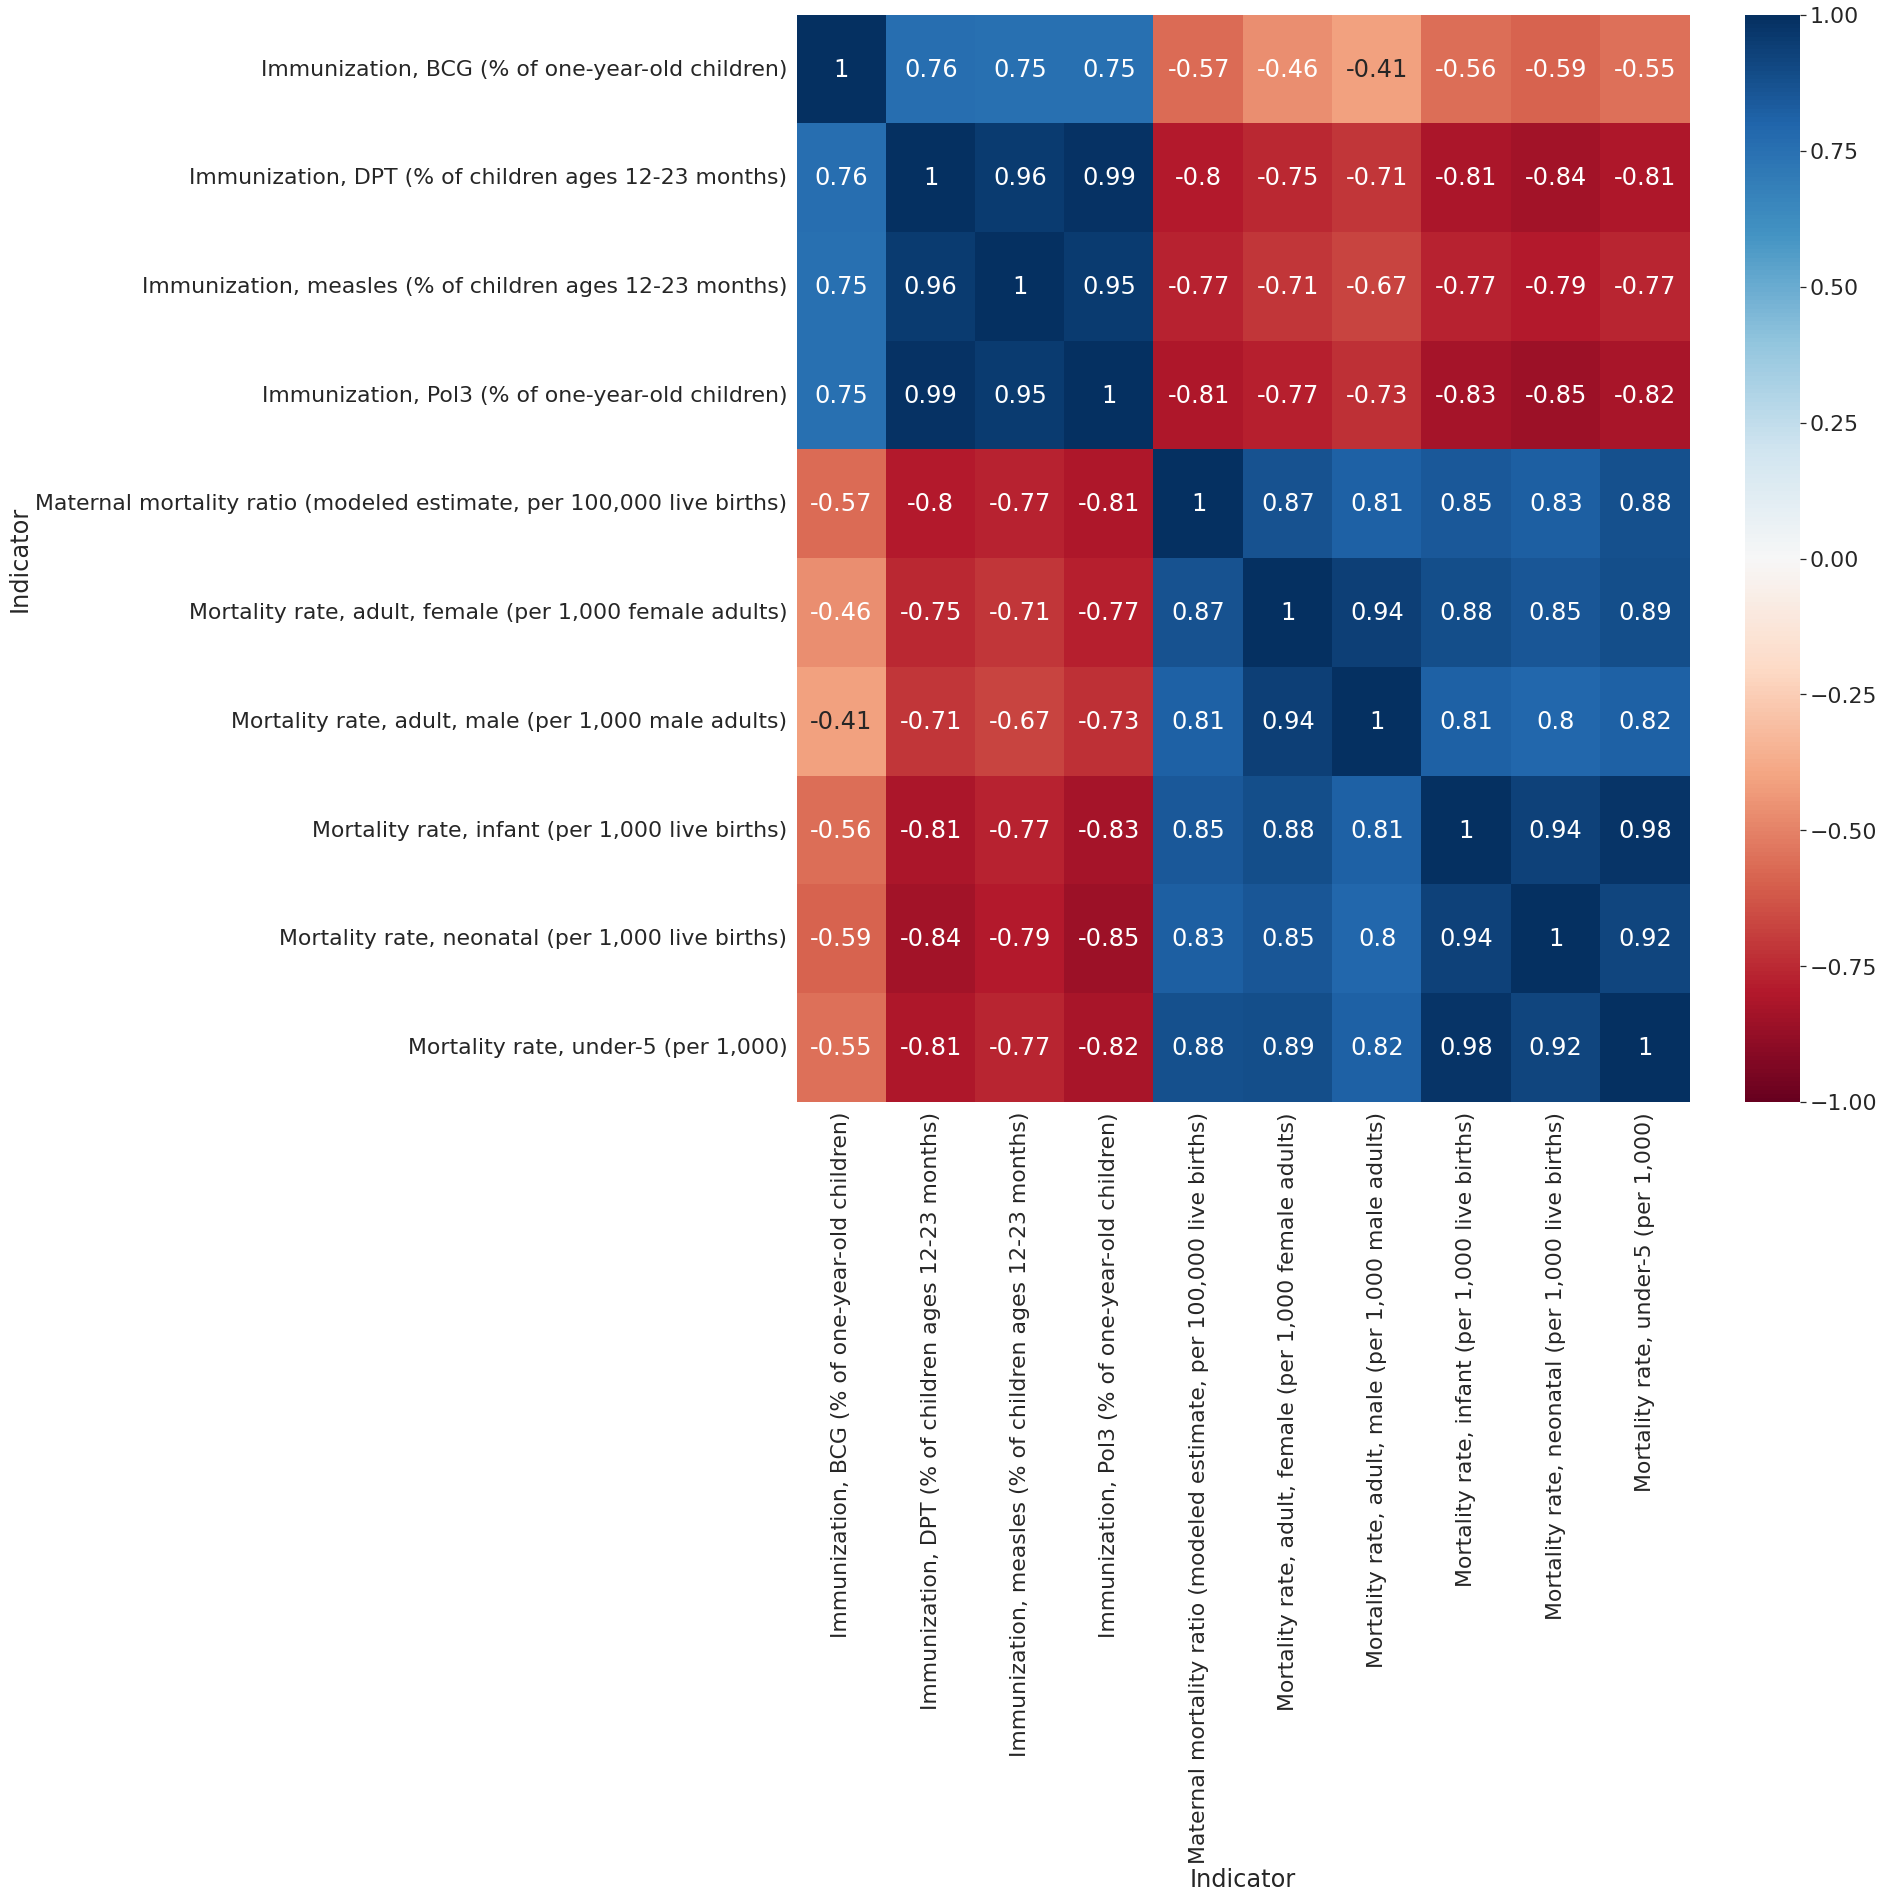

In [ ]:
immunization_mortality_df = numerics_df[['Immunization, BCG (% of one-year-old children)',
                                         'Immunization, DPT (% of children ages 12-23 months)',
                                         'Immunization, measles (% of children ages 12-23 months)',
                                         'Immunization, Pol3 (% of one-year-old children)',
                                         'Maternal mortality ratio (modeled estimate, per 100,000 live births)',
                                         'Mortality rate, adult, female (per 1,000 female adults)',
                                         'Mortality rate, adult, male (per 1,000 male adults)',
                                         'Mortality rate, infant (per 1,000 live births)',
                                         'Mortality rate, neonatal (per 1,000 live births)',
                                         'Mortality rate, under-5 (per 1,000)']]
corr_matrix = immunization_mortality_df.corr()

sns.set(font_scale=2)
plt.figure(figsize = (20, 20))
heatmap = sns.heatmap(corr_matrix, vmin = -1, vmax = 1, cmap='RdBu', annot=True)

**Analysis**: From the correlation figure above, we found that there are, in general, very strong negative correlations between the immunization rates and the mortality rates. And the DPT, measles, and Pol3 immunizations seem to have stronger correlation comparing to the BCG immunization.

### Correlation: Immunization vs. School Enrollment

We want to look at the correlation between different types of immunization (BCG, DPT, measles, and pols) and school enrollment (primary, secondary, tertiary). We guess that there is a positive correlation, but we are unsure about how strong the correlations are. We include all the related factors in the correlation map.

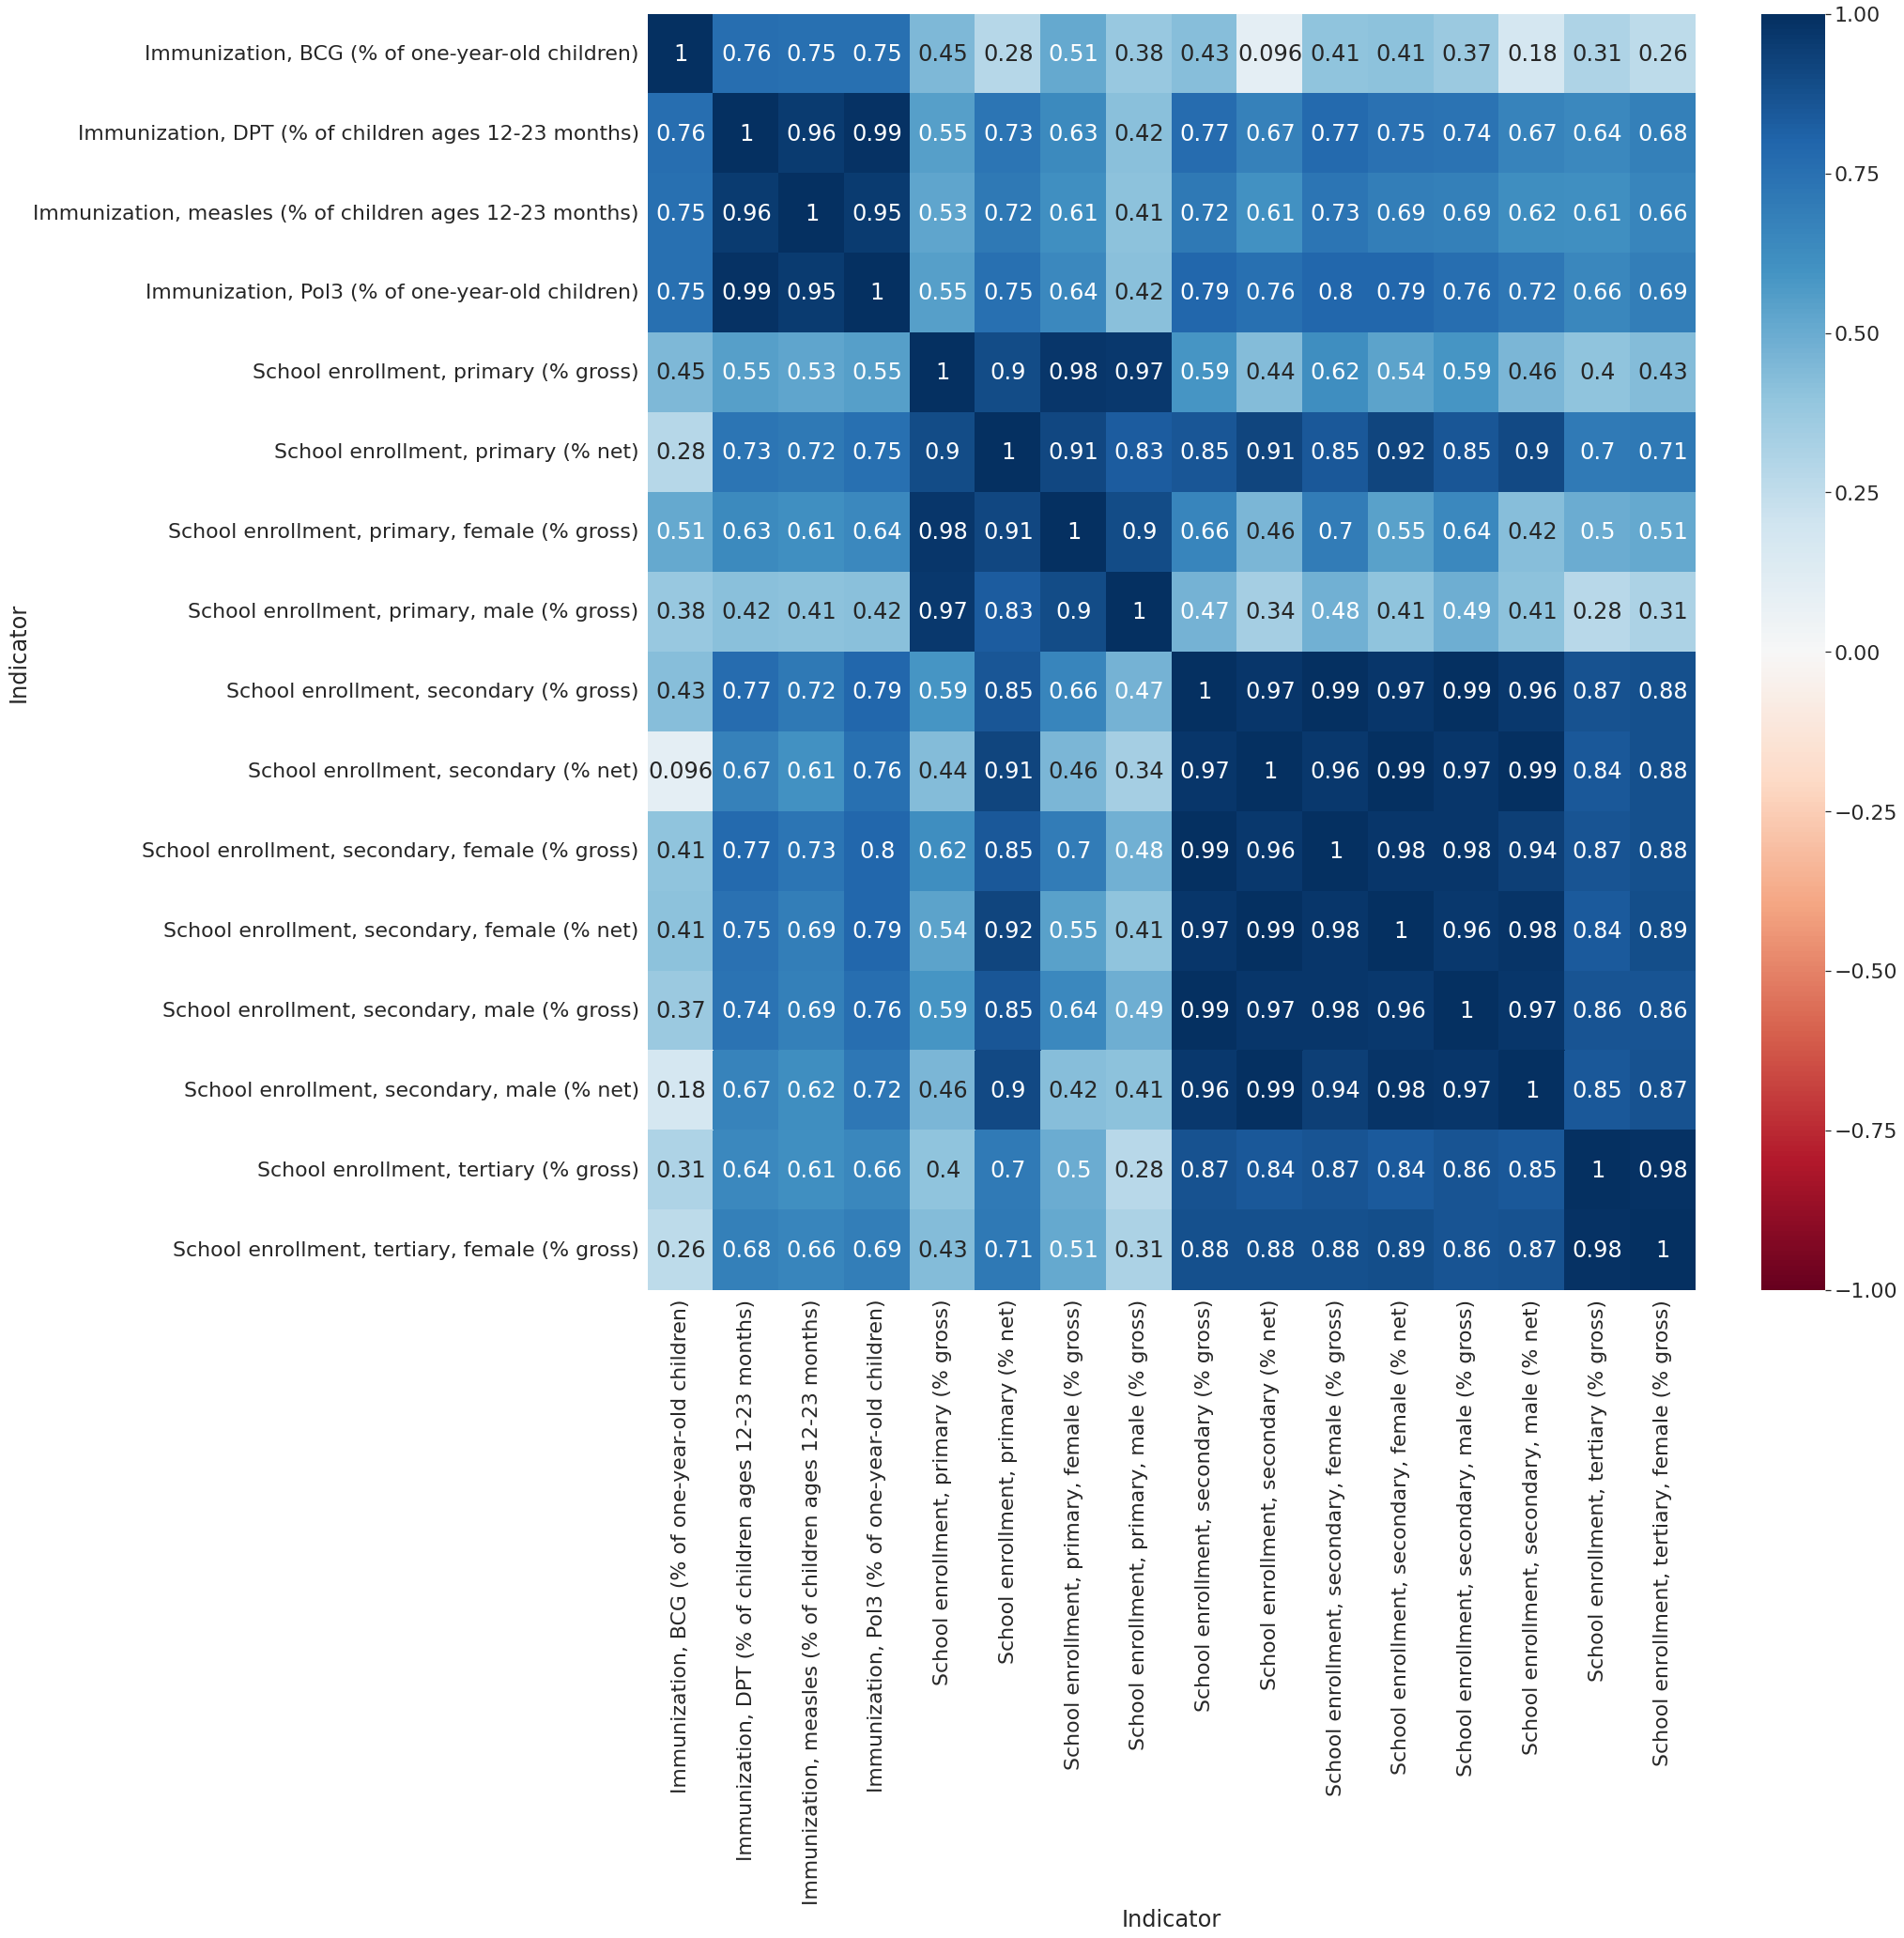

In [ ]:
imm_school_df = numerics_df[['Immunization, BCG (% of one-year-old children)',
                      'Immunization, DPT (% of children ages 12-23 months)',
                      'Immunization, measles (% of children ages 12-23 months)',
                      'Immunization, Pol3 (% of one-year-old children)',
                      'School enrollment, primary (% gross)',
                      'School enrollment, primary (% net)',
                      'School enrollment, primary, female (% gross)',
                      'School enrollment, primary, male (% gross)',
                      'School enrollment, secondary (% gross)',
                      'School enrollment, secondary (% net)',
                      'School enrollment, secondary, female (% gross)',
                      'School enrollment, secondary, female (% net)',
                      'School enrollment, secondary, male (% gross)',
                      'School enrollment, secondary, male (% net)',
                      'School enrollment, tertiary (% gross)',
                      'School enrollment, tertiary, female (% gross)']]
corr_matrix = imm_school_df.corr()

sns.set(font_scale=2)
plt.figure(figsize = (25, 25))
heatmap = sns.heatmap(corr_matrix, vmin = -1, vmax = 1, cmap='RdBu', annot=True)

**Analysis**: From the correlation figure above, we found that there are, in general, strong positive correlations between the immunization rates and the school enrollment rates. And the DPT, measles, and Pol3 immunizations seem to have stronger correlation comparing to the BCG immunization. Interestingly, this observation is similar to the immunization vs. mortality analysis, which shows that BCG immunization has the weakest correlation among the four immunizations.

### Correlation: Prevalence of HIV vs. open defecation
We want to look at the correlation between open defecation and HIV prevalence/incidence. We guess that there is a slight positive correlation, but we are unsure about the patterns for rural or urban defecation rate over HIV prevalence. We include all the related factors in the correlation map.

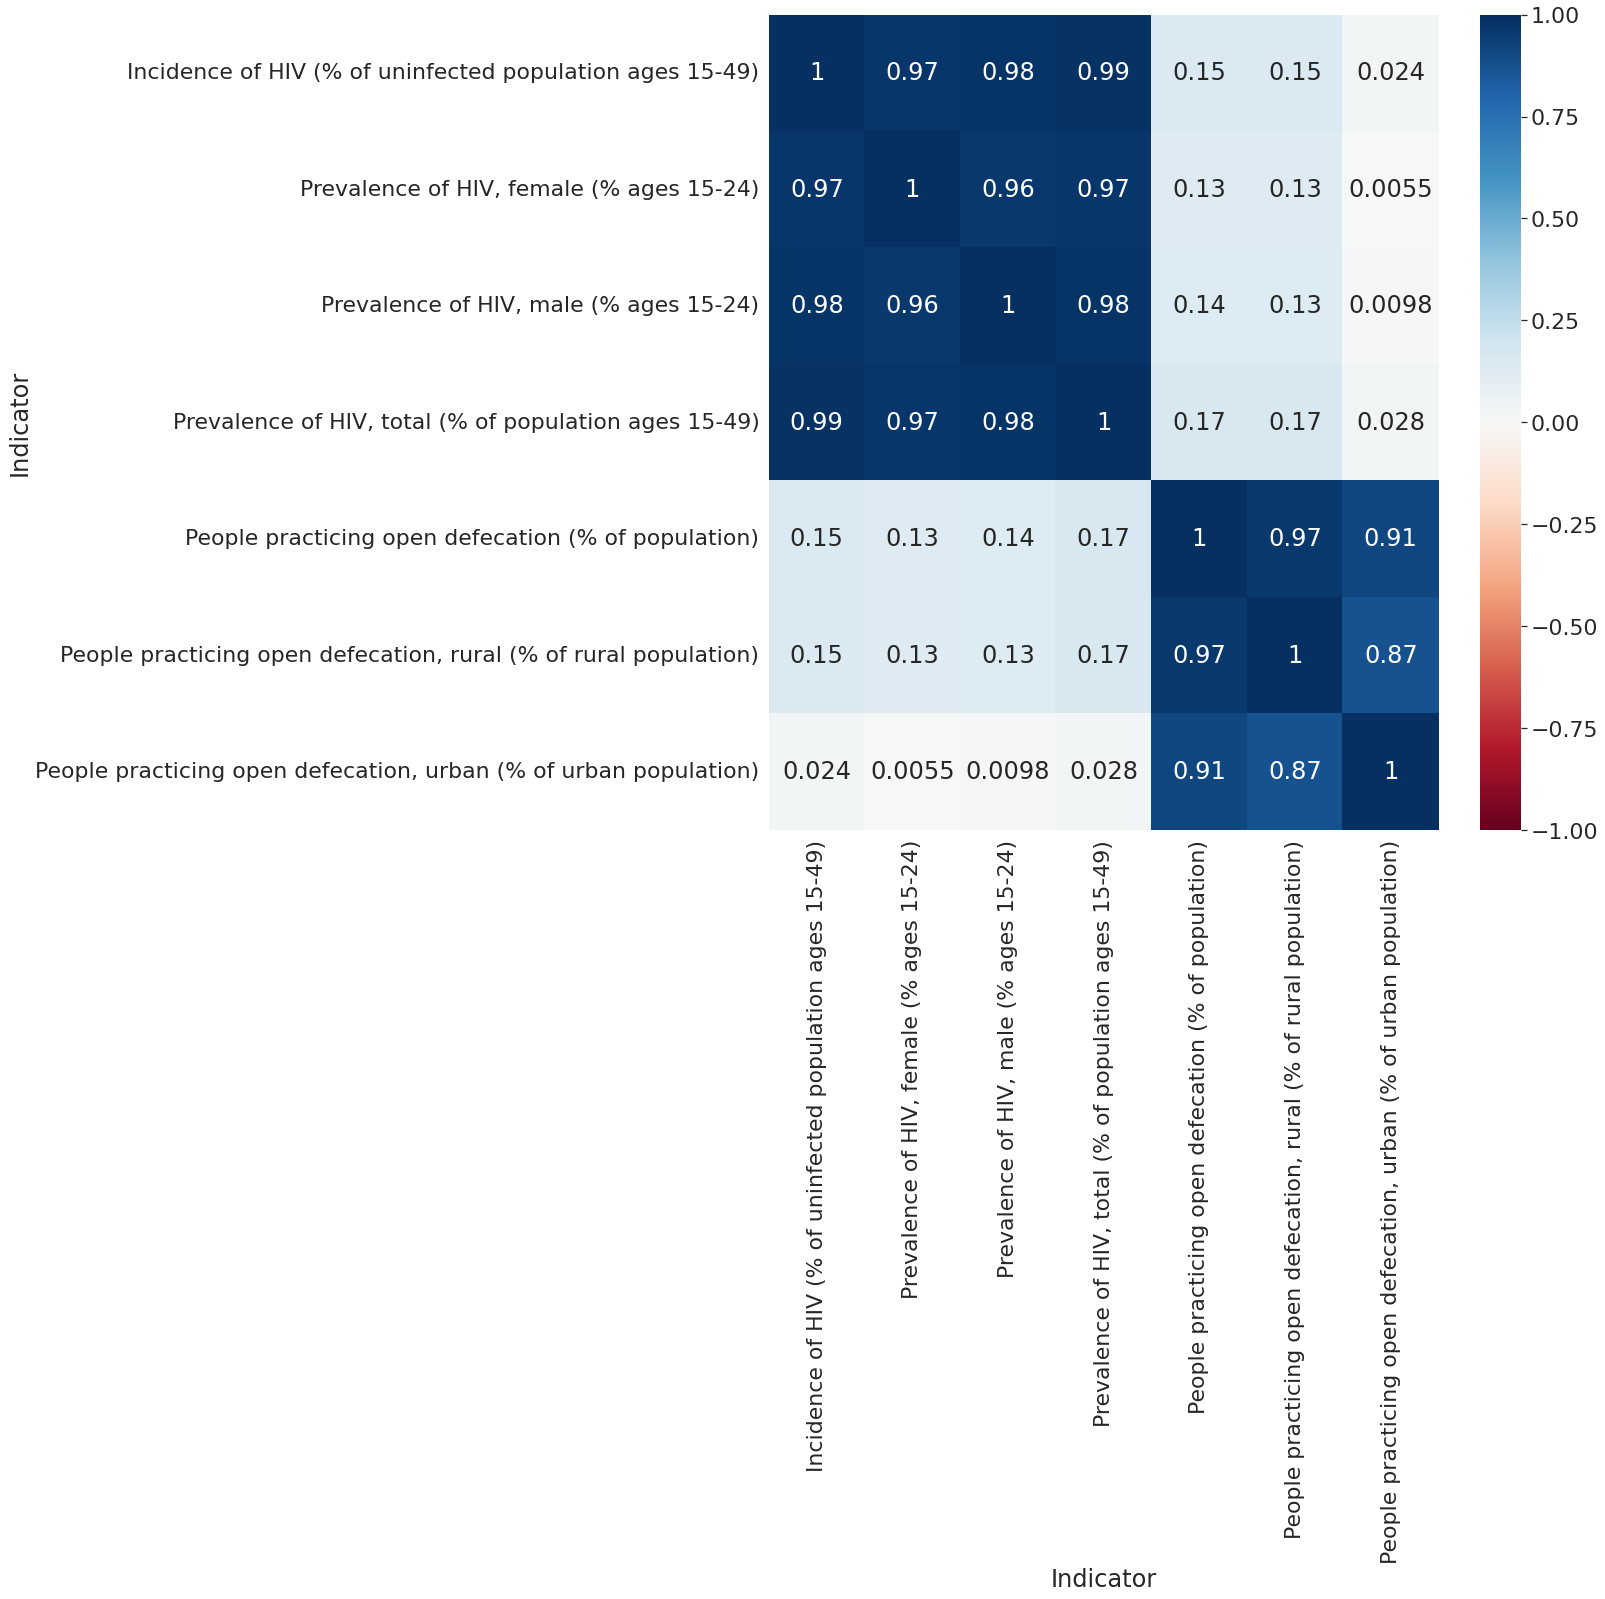

In [ ]:
hiv_prevalence_df = numerics_df[['Incidence of HIV (% of uninfected population ages 15-49)',
                      'Prevalence of HIV, female (% ages 15-24)',
                      'Prevalence of HIV, male (% ages 15-24)',
                      'Prevalence of HIV, total (% of population ages 15-49)',
                      'People practicing open defecation (% of population)',
                      'People practicing open defecation, rural (% of rural population)',
                      'People practicing open defecation, urban (% of urban population)']]
corr_matrix = hiv_prevalence_df.corr()

sns.set(font_scale=2)
plt.figure(figsize = (15, 15))
heatmap = sns.heatmap(corr_matrix, vmin = -1, vmax = 1, cmap='RdBu', annot=True)

**Analysis**: From the correlation map, rural area has a slightly positive correlation with HIV prevalence, and urban area has almost no correlation with HIV prevalence. Rural area seems to be more vulunerable to the open defecation. 

### Correlation: Prevalence of HIV vs. Improved sanitation facilities/ water source
Now, we want to look at the correlation between the prevalence of HIV and improved sanitation facilities/ water source. We guess that improved sanitation facilities/ water source will decrease the prevalence of HIV. Improved sanitation facilities will have a more negative correlarton than improved water source.

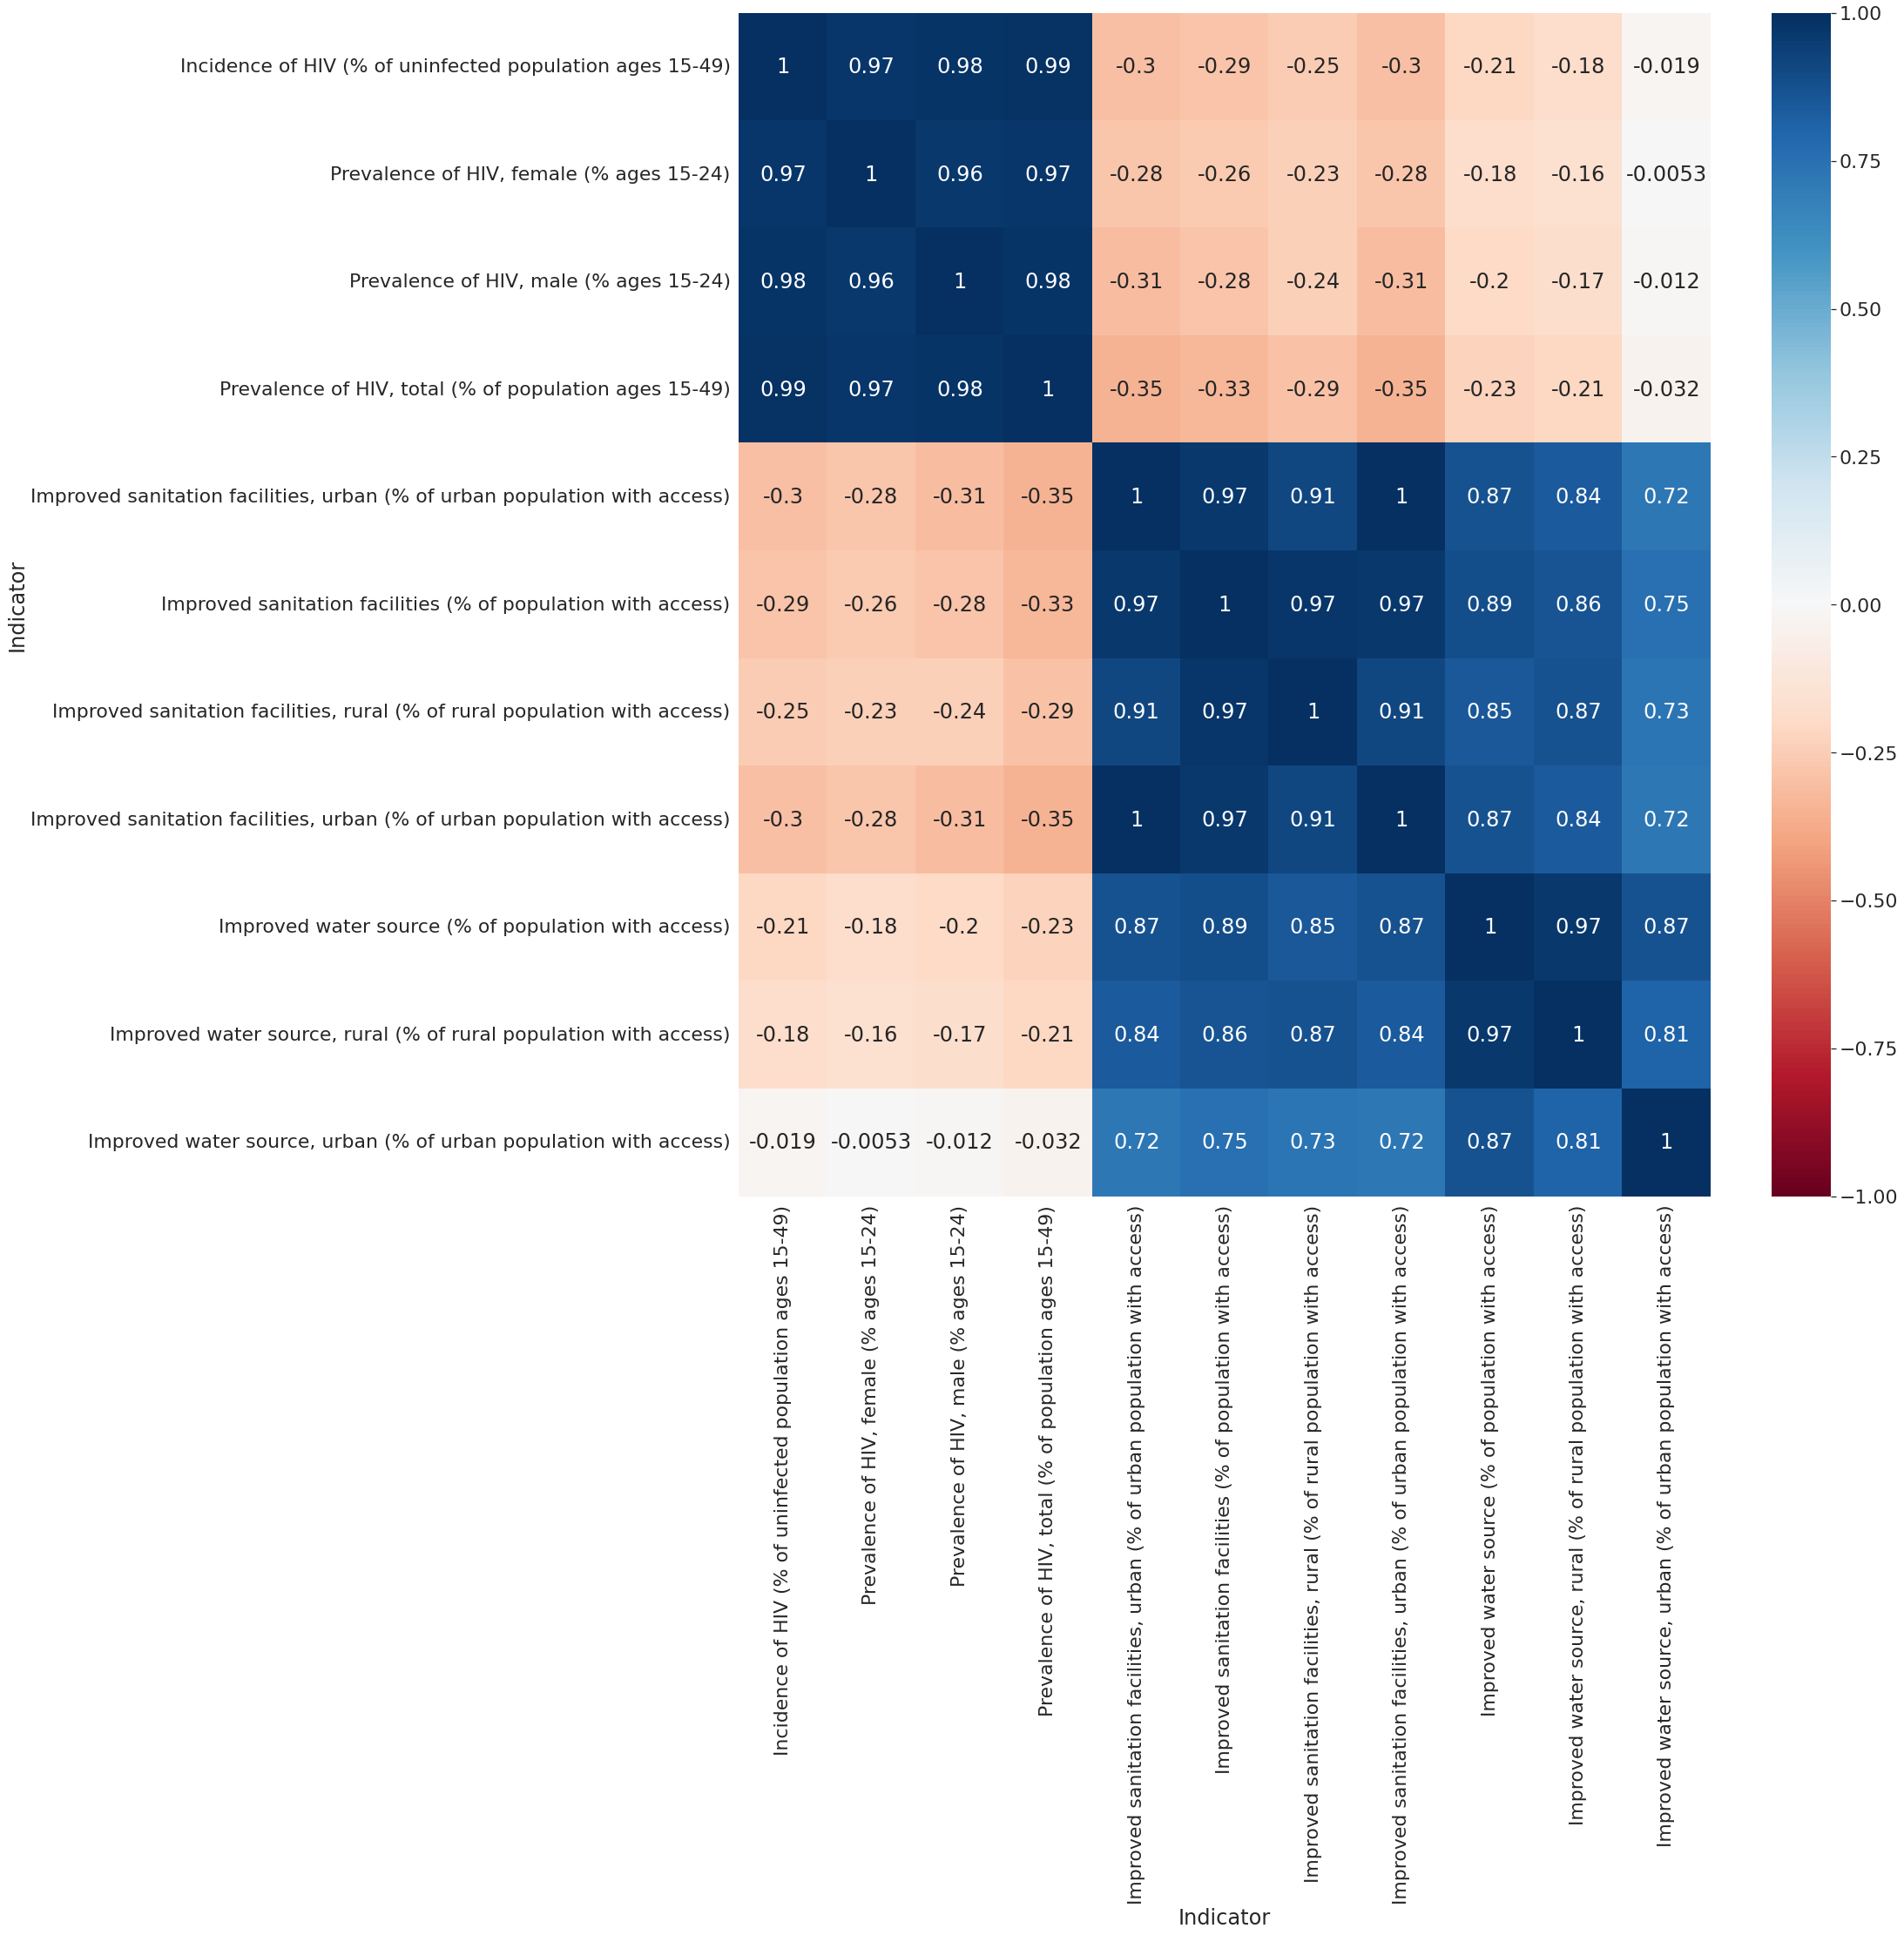

In [ ]:
hiv_improved_df = numerics_df[['Incidence of HIV (% of uninfected population ages 15-49)',
                            'Prevalence of HIV, female (% ages 15-24)',
                            'Prevalence of HIV, male (% ages 15-24)',
                            'Prevalence of HIV, total (% of population ages 15-49)',
                            'Improved sanitation facilities, urban (% of urban population with access)',
                            'Improved sanitation facilities (% of population with access)',
                            'Improved sanitation facilities, rural (% of rural population with access)',
                            'Improved sanitation facilities, urban (% of urban population with access)',
                            'Improved water source (% of population with access)',
                            'Improved water source, rural (% of rural population with access)',
                            'Improved water source, urban (% of urban population with access)']]
corr_matrix = hiv_improved_df.corr()

sns.set(font_scale=2)
plt.figure(figsize = (25, 25))
heatmap = sns.heatmap(corr_matrix, vmin = -1, vmax = 1, cmap='RdBu', annot=True)

**Analysis**: From the correlation map, there is a general negative correlation between improved water source/ sanitation facilities and HIV prevalence. And improved sanitation facilities decreased HIV prevalence more than improved water source. Moreover, improved water source in the urban area has nearly no relationship with HIV prevalence.

### Correlation:  Life Expectancy vs. Possible Indicators

We want to look at the correlation between life expectancy and indicators which we have investigated above. We include all the related factors in the correlation map.

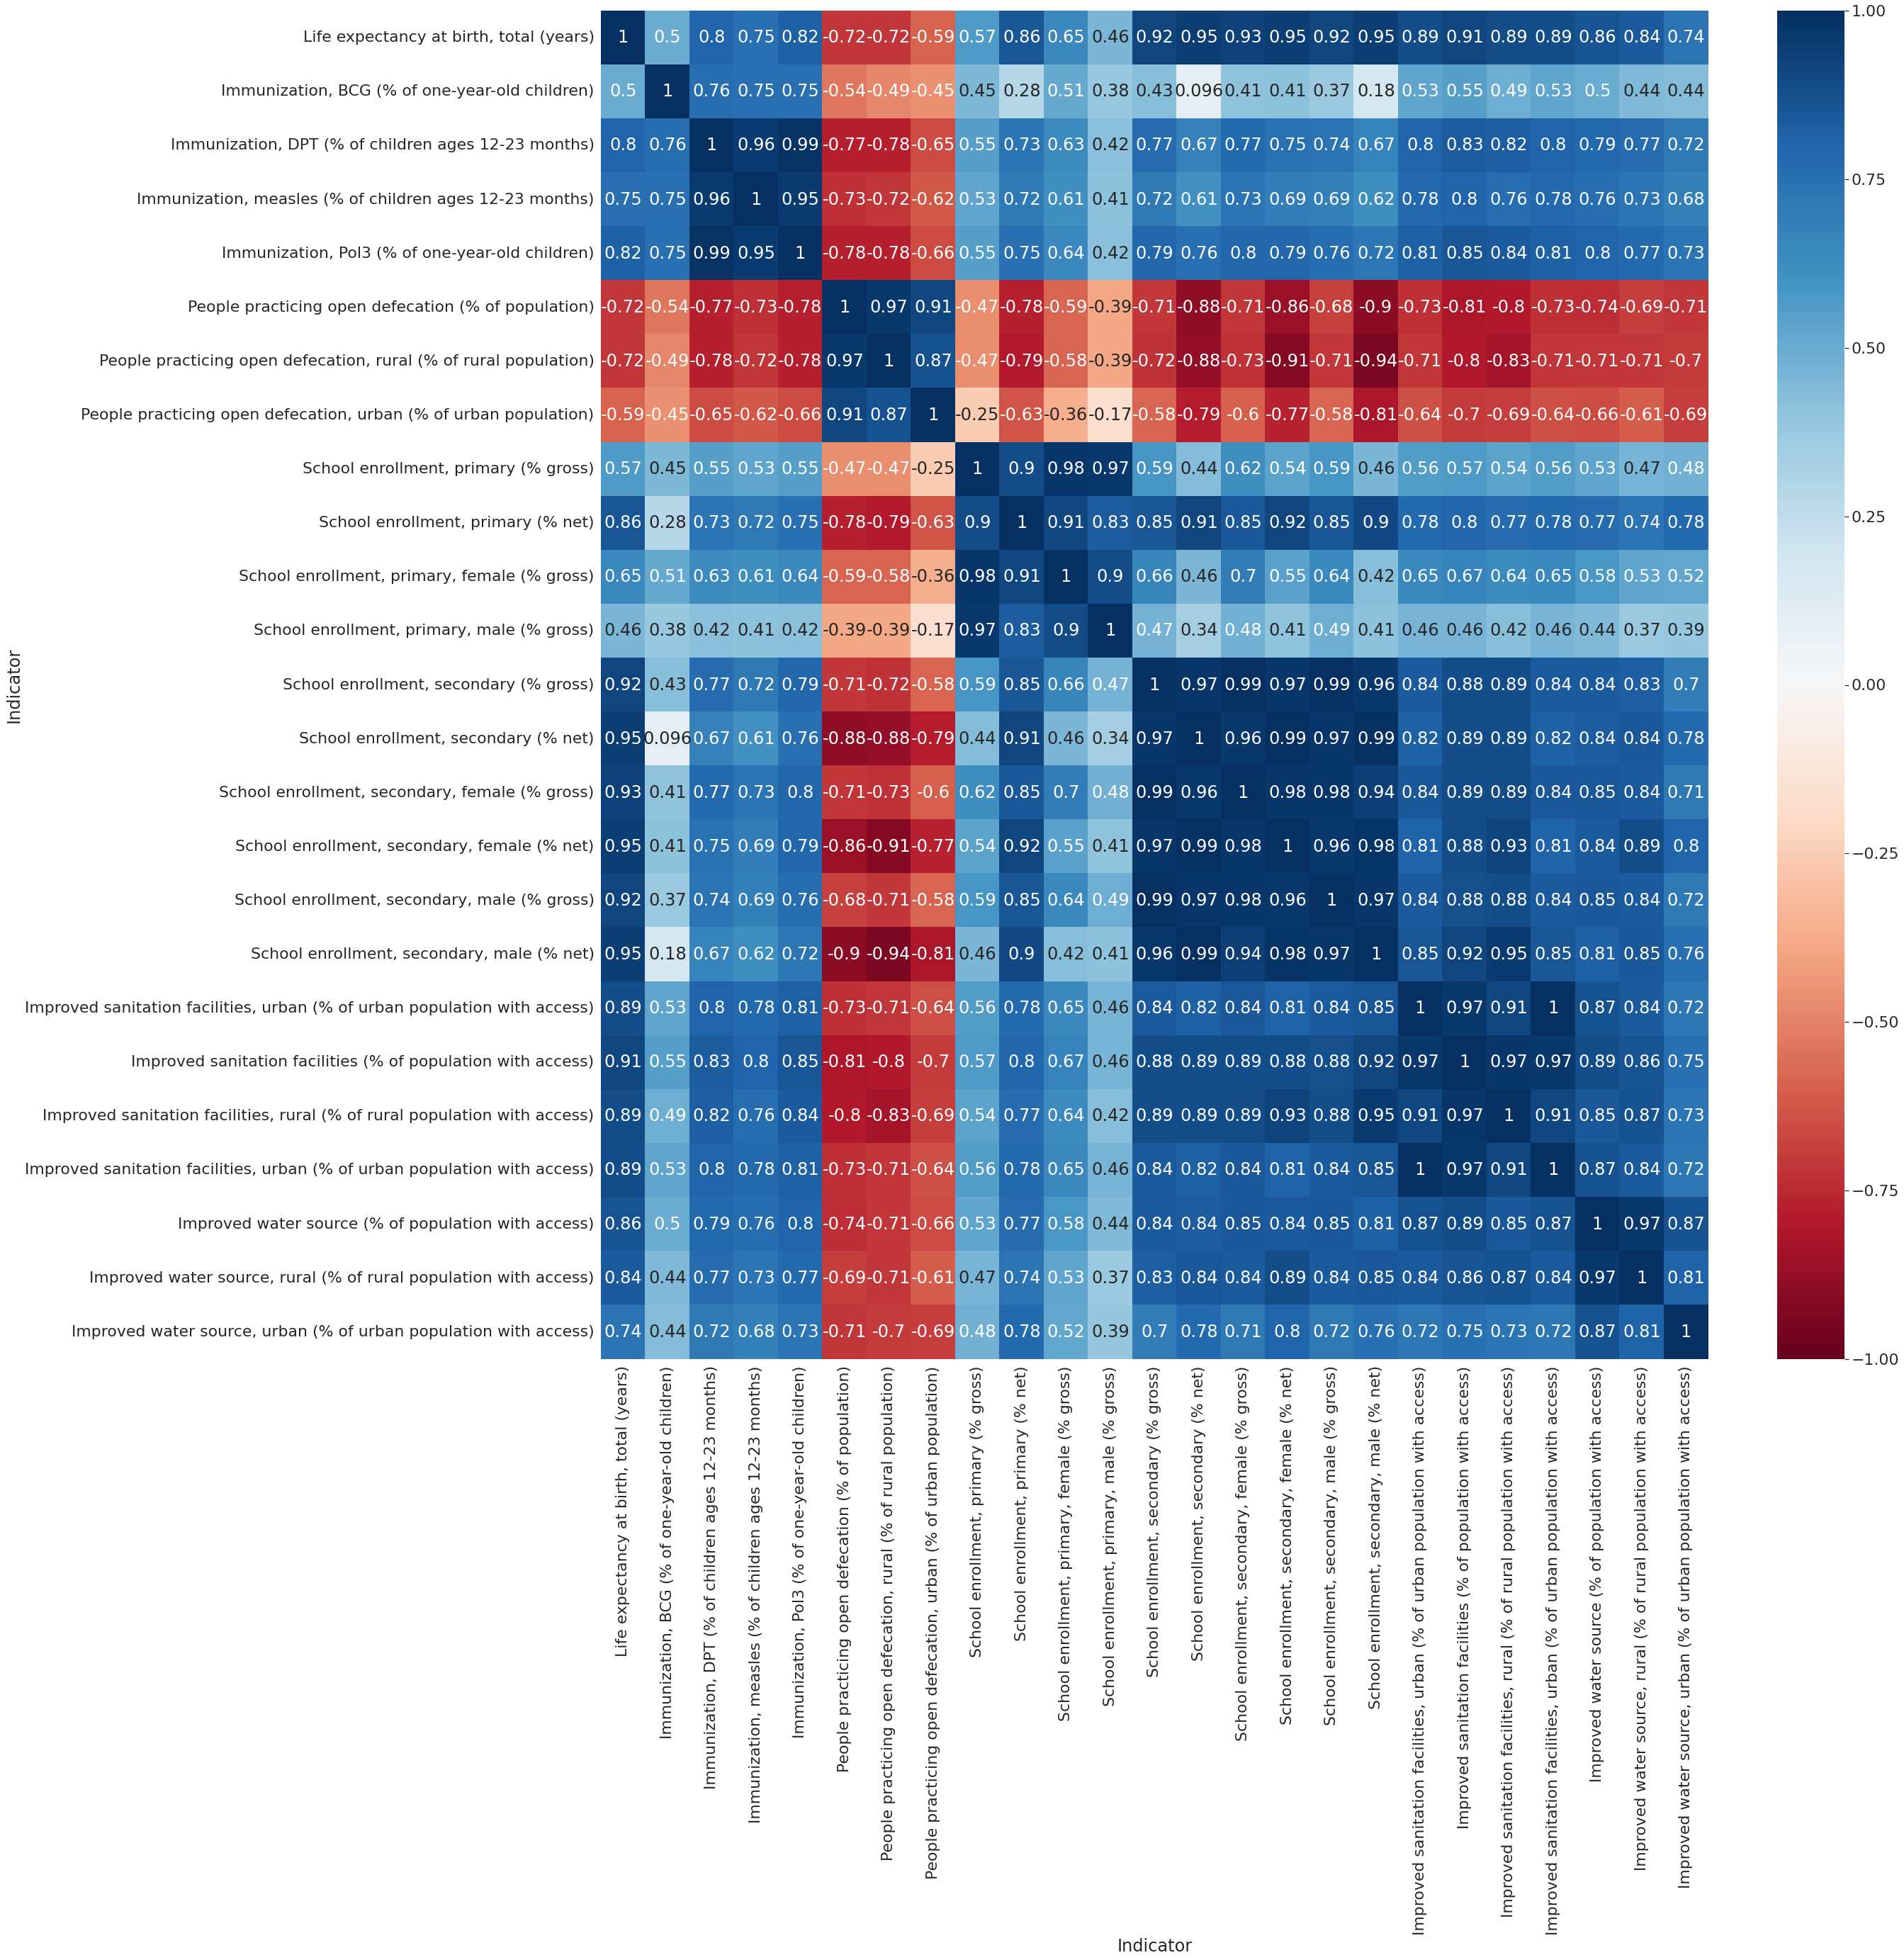

In [ ]:
life_expectancy_relevant_indicators_df = numerics_df[['Life expectancy at birth, total (years)', \
                      'Immunization, BCG (% of one-year-old children)', 'Immunization, DPT (% of children ages 12-23 months)', \
           'Immunization, measles (% of children ages 12-23 months)', 'Immunization, Pol3 (% of one-year-old children)', \
           'People practicing open defecation (% of population)', 'People practicing open defecation, rural (% of rural population)', \
           'People practicing open defecation, urban (% of urban population)', 'School enrollment, primary (% gross)', \
           'School enrollment, primary (% net)', 'School enrollment, primary, female (% gross)', \
           'School enrollment, primary, male (% gross)', 'School enrollment, secondary (% gross)', \
           'School enrollment, secondary (% net)', 'School enrollment, secondary, female (% gross)', \
           'School enrollment, secondary, female (% net)', 'School enrollment, secondary, male (% gross)', \
           'School enrollment, secondary, male (% net)', 'Improved sanitation facilities, urban (% of urban population with access)', \
           'Improved sanitation facilities (% of population with access)', \
           'Improved sanitation facilities, rural (% of rural population with access)', \
           'Improved sanitation facilities, urban (% of urban population with access)', \
           'Improved water source (% of population with access)', 'Improved water source, rural (% of rural population with access)', \
           'Improved water source, urban (% of urban population with access)']]
corr_matrix = life_expectancy_relevant_indicators_df.corr()

sns.set(font_scale=2)
plt.figure(figsize = (35, 35))
heatmap = sns.heatmap(corr_matrix, vmin = -1, vmax = 1, cmap='RdBu', annot=True)

**Analysis**: From the correlation figure above, we found that there are, in general, strong correlations between the life expectancy and the selected relevant indicators. Therefore, we will fit a linear model later to use thses indicators as feature vectors and life expectancy as targets.

### K-means Clustering:  Country/ Region Clusters

#### KNN Value Inputation

We find out that there are many missing values in the table, which will be hard to implement some models in the future, therefore, we decided to fill these missing values using the K Nearest Neighbor method.

In [ ]:
df_pivot_avg_health_population_stats

Indicator             Country  AIDS estimated deaths (UNAIDS estimates)  \
0                 Afghanistan                              2.500000e+02   
1                     Albania                                       NaN   
2                     Algeria                              1.576923e+02   
3              American Samoa                                       NaN   
4                     Andorra                                       NaN   
..                        ...                                       ...   
253        West Bank and Gaza                                       NaN   
254                     World                              1.306538e+06   
255               Yemen, Rep.                              3.115385e+02   
256                    Zambia                              4.400000e+04   
257                  Zimbabwe                              7.353846e+04   

Indicator  Adolescent fertility rate (births per 1,000 women ages 15-19)  \
0                                                 143.565807               
1                                                  26.088338               
2                                                  53.864244               
3                                                        NaN               
4                                                        NaN               
..                                                       ...               
253                                                95.569644               
254                                                65.229633               
255                                               132.776600               
256                                               160.726538               
257                                               135.117775               

Indicator  Adults (ages 15+) and children (0-14 years) living with HIV  \
0                                               2.869231e+03             
1                                                        NaN             
2                                               3.946154e+03             
3                                                        NaN             
4                                                        NaN             
..                                                       ...             
253                                                      NaN             
254                                             2.716923e+07             
255                                             4.161538e+03             
256                                             9.073077e+05             
257                                             1.367308e+06             

Indicator  Adults (ages 15+) and children (ages 0-14) newly infected with HIV  \
0                                               6.115385e+02                    
1                                                        NaN                    
2                                               6.538462e+02                    
3                                                        NaN                    
4                                                        NaN                    
..                                                       ...                    
253                                                      NaN                    
254                                             2.646154e+06                    
255                                             7.307692e+02                    
256                                             8.380769e+04                    
257                                             1.245000e+05                    

Indicator  Adults (ages 15+) living with HIV  \
0                               2.769231e+03   
1                                        NaN   
2                               3.869231e+03   
3                                        NaN   
4                                        NaN   
..                                  

We choose the value of K to be 3, and fill the missing values.

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 3)
df_pivot_avg_health_population_stats_imputed = imputer.fit_transform(df_pivot_avg_health_population_stats.select_dtypes(include='float64'))
df_pivot_avg_health_population_stats_imputed

array([[2.50000000e+02, 1.43565807e+02, 2.86923077e+03, ...,
        4.49291653e+00, 3.96884615e+01, 2.69900977e+01],
       [3.70897436e+03, 2.60883382e+01, 5.98307692e+04, ...,
        2.25917113e+00, 3.96884615e+01, 4.17970457e+01],
       [1.57692308e+02, 5.38642436e+01, 3.94615385e+03, ...,
        3.87021667e+00, 3.96884615e+01, 3.77073334e+01],
       ...,
       [3.11538462e+02, 1.32776600e+02, 4.16153846e+03, ...,
        5.43541319e+00, 3.96884615e+01, 3.20956708e+01],
       [4.40000000e+04, 1.60726538e+02, 9.07307692e+05, ...,
        4.56704842e+00, 3.96884615e+01, 5.67825999e+01],
       [7.35384615e+04, 1.35117775e+02, 1.36730769e+06, ...,
        4.31628281e+00, 3.96884615e+01, 5.71100833e+01]])

The table is full now, but the data are not in the same scale. Some of the models such as PCA and regression with regularization is scale-sensitive. Therefore, we will standarize all the values in the table.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_pivot_avg_health_population_stats_imputed)
df_pivot_avg_health_population_stats_imputed_scaled = scaler.transform(df_pivot_avg_health_population_stats_imputed)

#### K-Means Clustering

Then, we use the K-Means method to filter all the health statistics of different country into 5 clusters.

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(df_pivot_avg_health_population_stats_imputed_scaled)
kmeans.labels_

array([1, 3, 3, 3, 3, 1, 3, 3, 0, 3, 0, 0, 0, 3, 3, 3, 1, 0, 0, 0, 3, 1,
       3, 1, 1, 0, 1, 3, 3, 3, 0, 1, 1, 3, 1, 1, 0, 3, 3, 1, 0, 1, 0, 3,
       2, 3, 1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 1, 3, 3, 2, 2, 2, 2, 3, 3,
       3, 1, 1, 0, 1, 0, 2, 0, 0, 0, 3, 3, 0, 1, 0, 3, 3, 1, 0, 0, 1, 3,
       0, 3, 3, 3, 1, 1, 1, 3, 1, 1, 2, 3, 0, 0, 0, 2, 3, 3, 3, 0, 3, 0,
       0, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 0, 1, 3, 1, 1,
       3, 3, 0, 4, 1, 2, 0, 0, 0, 1, 1, 3, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3,
       3, 4, 0, 3, 3, 0, 3, 1, 3, 1, 3, 1, 0, 3, 0, 3, 1, 1, 0, 3, 0, 2,
       3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 0, 0, 2, 1, 0, 3, 0, 0, 1, 3, 3, 3,
       3, 1, 0, 3, 1, 0, 4, 0, 0, 3, 3, 1, 3, 2, 2, 1, 0, 3, 3, 3, 3, 3,
       1, 1, 1, 1, 3, 1, 0, 0, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1,
       0, 3, 0, 0, 2, 0, 3, 3, 3, 3, 0, 3, 4, 1, 1, 1], dtype=int32)

Finally, we trasnsfer the table back to a pandas dataframe and bring back the 'Country' column and renaming the cluster column it as 'Cluster'.

In [ ]:
cluster_df = pd.DataFrame(kmeans.labels_)
cluster_df['Country'] = df_pivot_avg_health_population_stats['Country']
cluster_df = cluster_df.rename(columns={0: "Cluster"})

#### World Map for The Country/ Region Clusters

Now, we want to plot the world map of  the different clusters of overall health statistics data around the world.



The following map may not be able to show up in a local computer, since it is an interactive image. The map can be shown normally on Colab, so please kindly upload this .ipynb file to Colab and view it there if there is an issue viewing the map.

In [ ]:
fig = px.choropleth(data_frame = cluster_df, locations="Country", locationmode = 'country names',
                    color="Cluster", color_continuous_scale=px.colors.sequential.Inferno, 
                    title = 'Clusters of Overall Health Statistics Data around The World')

fig.show()

**Analysis:** The result is very useful. Countries in North America, Europe, Oceania and Argentina are classified into the same group, they represent the group of developed countries. Argentina was once a developed country, and since the data contained years starting from 1960, it is not that surprise that Argentina is in this group.
The second group are China and India. They represent the country with super lagre population. Since some factors are based on the count of cases from the total population, China and India will definitely have a much higher value than other countries due to the larg population base.
The next group contains countries in Central Africa and countries like Bolivia, Pakistan. They represent the developing countries with poor health conditions. The countries in North Africa, South Africa and West Asia are classified into one group, they are also developing countries, but generally have a better health conditon than the previous group.

### World Map for Average Urban Population Rate (1960 - 2015)

Now, we would love to gain more insights about another interesting indicator, urban population rate, and let's look at the world map of avergae urban population rate from 1960 to 2015.

The following map may not be able to show up in a local computer, since it is an interactive image. The map can be shown normally on Colab, so please kindly upload this .ipynb file to Colab and view it there if there is an issue viewing the map.

In [ ]:
urban_population_df = df_pivot_avg_health_population_stats[['Country','Urban population (% of total)']]

fig = px.choropleth(data_frame = urban_population_df, locations="Country", locationmode = 'country names',
                    color='Urban population (% of total)', hover_name='Urban population (% of total)',
                    color_continuous_scale=px.colors.sequential.Inferno,
                    title = 'Average Urban Population Rate (1960 - 2015) around The World')

fig.show()

**Analysis:**  Austrilia, USA and Canada have the highest average urban population rate, follewed by countries in western Europe and Argentina, and some countries in western Asia. The countries with the lowest average urban population rate are countries in Afica, East Asia. It is supursied that China has such low average urban population rate, this may due to the low figure at the early years. Therefore, we deciede to add the examination of the urban population rate at different years in later chapter.

### World Map for Average Life Expentency (1960 - 2015)

Now, we look at the world map for life expectency at birth.

The following map may not be able to show up in a local computer, since it is an interactive image. The map can be shown normally on Colab, so please kindly upload this .ipynb file to Colab and view it there if there is an issue viewing the map.

In [ ]:
life_expectancy_df = df_pivot_avg_health_population_stats[['Country','Life expectancy at birth, total (years)']]

fig = px.choropleth(data_frame = life_expectancy_df, locations="Country", locationmode = 'country names',
                    color='Life expectancy at birth, total (years)', hover_name='Life expectancy at birth, total (years)',
                    color_continuous_scale=px.colors.sequential.Inferno,
                    title = 'Life Expectancy at Birth around The World')

fig.show()

**Analysis:** Countries like Canada, USA and Austrilia have the highest life expectency at birth. The figure for European, Asian and South America countires are also pretty high. Countries in Africa have the the lowest life expectency at birth. Some of the counyries even have a figure of just over 40, which is quite astonishing.

## Time Series Analysis

In this part, we are mainly focusing on analyzing the trends and seasonal changes across the period from 1960 to 2015 for different indicators. So we decided to use data for each individual year.

In [ ]:
# Here is the dataframe for the time series of each indicator for country/ regions.
df_health_population_stats_clean

Country                                          Indicator  \
0      Arab World  Adolescent fertility rate (births per 1,000 wo...   
1      Arab World  Age dependency ratio (% of working-age populat...   
2      Arab World                          Age dependency ratio, old   
3      Arab World                        Age dependency ratio, young   
4      Arab World               Birth rate, crude (per 1,000 people)   
...           ...                                                ...   
43734    Zimbabwe             Survival to age 65, male (% of cohort)   
43735    Zimbabwe                                   Urban population   
43736    Zimbabwe                      Urban population (% of total)   
43737    Zimbabwe                 Urban population growth (annual %)   
43738    Zimbabwe  Women's share of population ages 15+ living wi...   

                1960           1961           1962           1963  \
0         133.555013     134.159119     134.857912     134.504576   
1          87.799235      89.221714      90.502403      91.603014   
2           6.635328       6.746978       6.840980       6.915871   
3          81.024250      82.316142      83.459807      84.413972   
4          47.699716      47.457093      47.199572      46.919206   
...              ...            ...            ...            ...   
43734      43.355800      43.888050      44.420300      44.878710   
43735  473101.000000  497024.000000  524099.000000  562238.000000   
43736      12.608000      12.821000      13.082000      13.578000   
43737       4.897746       4.932942       5.304228       7.024465   
43738            NaN            NaN            NaN            NaN   

                1964           1965           1966           1967  ...  \
0         134.105211     133.569626     132.675635     131.665502  ...   
1          92.414916      92.868163      93.733950      94.100279  ...   
2           6.968155       6.996499       7.065913       7.105005  ...   
3          85.096657      85.470717      86.246560      86.590857  ...   
4          46.611790      46.270750      45.892127      45.483407  ...   
...              ...            ...            ...            ...  ...   
43734      45.337110      45.795520      46.253920      46.712330  ...   
43735  603076.000000  646516.000000  692786.000000  742096.000000  ...   
43736      14.092000      14.620000      15.165000      15.727000  ...   
43737       7.011798       6.955472       6.912320       6.875747  ...   
43738            NaN            NaN            NaN            NaN  ...   

               2006          2007          2008          2009          2010  \
0      5.032914e+01  4.999985e+01  4.988705e+01  4.978121e+01  4.967297e+01   
1      6.578673e+01  6.463007e+01  6.360263e+01  6.273802e+01  6.205350e+01   
2      6.821022e+00  6.765206e+00  6.712015e+00  6.672599e+00  6.653749e+00   
3      5.735923e+01  5.616857e+01  5.512340e+01  5.425597e+01  5.357864e+01   
4      2.727014e+01  2.728815e+01  2.732055e+01  2.737012e+01  2.742164e+01   
...             ...           ...           ...           ...           ...   
43734  2.240553e+01  2.378692e+01  2.722864e+01  3.067035e+01  3.411207e+01   
43735  4.453786e+06  4.487076e+06  4.529077e+06  4.579794e+06  4.638775e+06   
43736  3.392600e+01  3.374300e+01  3.356000e+01  3.337800e+01  3.319600e+01   
43737  5.584083e-01  7.446744e-01  9.316901e-01  1.113585e+00  1.279630e+00   
43738  5.833127e+01  5.858609e+01  5.876080e+01  5.881242e+01  5.882594e+01   

               2011          2012          2013          2014          2015  
0      4.953605e+01  4.938374e+01  4.879656e+01  4.819642e+01           NaN  
1      6.179494e+01  6.168190e+01  6.167869e+01  6.171979e+01  6.175419e+01  
2      6.678820e+00  6.715494e+00  6.767541e+00  6.840458e+00  6.937488e+00  
3      5.331823e+01  5.320907e+01  5.320536e+01  5.322831e+01  5.321811e+01  
4      2.739020e+01  2.728440e+01  2.706754e+01  2.674617e+01           NaN  
...       

### Time series: Prevalence of HIV

We take a look at the 'Prevalence of HIV, total (% of population ages 15-49)' factor, and store the rows with this factor into the df_hiv_15_49_all dataframe.

In [ ]:
df_health_population_stats_clean_copy = df_health_population_stats_clean.copy()
df_hiv_15_49_all = df_health_population_stats_clean_copy[df_health_population_stats_clean_copy['Indicator'] == 'Prevalence of HIV, total (% of population ages 15-49)'].reset_index(drop=True)
df_hiv_15_49_all

Country  \
0                                  Arab World   
1                      Caribbean small states   
2    Fragile and conflict affected situations   
3      Heavily indebted poor countries (HIPC)   
4                   Latin America & Caribbean   
..                                        ...   
118                             Venezuela, RB   
119                                   Vietnam   
120                               Yemen, Rep.   
121                                    Zambia   
122                                  Zimbabwe   

                                             Indicator  1960  1961  1962  \
0    Prevalence of HIV, total (% of population ages...   NaN   NaN   NaN   
1    Prevalence of HIV, total (% of population ages...   NaN   NaN   NaN   
2    Prevalence of HIV, total (% of population ages...   NaN   NaN   NaN   
3    Prevalence of HIV, total (% of population ages...   NaN   NaN   NaN   
4    Prevalence of HIV, total (% of population ages...   NaN   NaN   NaN   
..                                                 ...   ...   ...   ...   
118  Prevalence of HIV, total (% of population ages...   NaN   NaN   NaN   
119  Prevalence of HIV, total (% of population ages...   NaN   NaN   NaN   
120  Prevalence of HIV, total (% of population ages...   NaN   NaN   NaN   
121  Prevalence of HIV, total (% of population ages...   NaN   NaN   NaN   
122  Prevalence of HIV, total (% of population ages...   NaN   NaN   NaN   

     1963  1964  1965  1966  1967  ...       2006       2007       2008  \
0     NaN   NaN   NaN   NaN   NaN  ...   0.148418   0.146902   0.146779   
1     NaN   NaN   NaN   NaN   NaN  ...   1.662116   1.660820   1.626350   
2     NaN   NaN   NaN   NaN   NaN  ...   2.075667   1.975755   1.901020   
3     NaN   NaN   NaN   NaN   NaN  ...   3.433305   3.337061   3.278390   
4     NaN   NaN   NaN   NaN   NaN  ...   0.475703   0.474864   0.463080   
..    ...   ...   ...   ...   ...  ...        ...        ...        ...   
118   NaN   NaN   NaN   NaN   NaN  ...   0.500000   0.500000   0.500000   
119   NaN   NaN   NaN   NaN   NaN  ...   0.400000   0.400000   0.400000   
120   NaN   NaN   NaN   NaN   NaN  ...   0.100000   0.100000   0.100000   
121   NaN   NaN   NaN   NaN   NaN  ...  13.800000  13.600000  13.600000   
122   NaN   NaN   NaN   NaN   NaN  ...  17.200000  16.500000  16.000000   

          2009       2010       2011       2012       2013       2014  \
0     0.146341   0.145276   0.141830   0.141759   0.140309   0.154971   
1     1.639947   1.600095   1.605970   1.594140   1.599812   1.557831   
2     1.822493   1.749634   1.682973   1.629608   1.585080   1.545550   
3     3.213067   3.147459   3.080862   3.005434   2.945793   2.883961   
4     0.457907   0.456256   0.449874   0.477686   0.472880   0.480232   
..         ...        ...        ...        ...        ...        ...   
118   0.500000   0.500000   0.500000   0.500000   0.500000   0.500000   
119   0.400000   0.500000   0.500000   0.500000   0.500000   0.500000   
120   0.100000   0.100000   0.100000   0.100000   0.100000   0.100000   
121  13.500000  13.500000  13.400000  13.300000  13.200000  13.100000   
122  15.700000  15.500000  15.300000  15.200000  15.000000  14.900000   

          2015  
0     0.155495  
1     1.556805  
2     1.497368  
3     2.803931  
4     0.475103  
..         ...  
118   0.500000  
119   0.500000  
120   0.100000  
121  12.900000  
122  14.700000  

[123 rows x 58 columns]

#### Drop missing value
We found out that many early years did not have a value, so we decide to drop all the missing values.

In [ ]:
df_hiv_15_49_all = df_hiv_15_49_all.dropna(axis=1)
df_hiv_15_49_all

Country  \
0                                  Arab World   
1                      Caribbean small states   
2    Fragile and conflict affected situations   
3      Heavily indebted poor countries (HIPC)   
4                   Latin America & Caribbean   
..                                        ...   
118                             Venezuela, RB   
119                                   Vietnam   
120                               Yemen, Rep.   
121                                    Zambia   
122                                  Zimbabwe   

                                             Indicator       1990       1991  \
0    Prevalence of HIV, total (% of population ages...   0.102899   0.103273   
1    Prevalence of HIV, total (% of population ages...   0.587821   0.757727   
2    Prevalence of HIV, total (% of population ages...   1.477198   1.688802   
3    Prevalence of HIV, total (% of population ages...   2.822451   3.091349   
4    Prevalence of HIV, total (% of population ages...   0.299226   0.334260   
..                                                 ...        ...        ...   
118  Prevalence of HIV, total (% of population ages...   0.100000   0.100000   
119  Prevalence of HIV, total (% of population ages...   0.100000   0.100000   
120  Prevalence of HIV, total (% of population ages...   0.100000   0.100000   
121  Prevalence of HIV, total (% of population ages...  12.400000  13.500000   
122  Prevalence of HIV, total (% of population ages...  15.000000  17.700000   

          1992       1993       1994       1995       1996       1997  ...  \
0     0.108891   0.109868   0.115472   0.121297   0.122236   0.128106  ...   
1     0.918493   1.061801   1.205780   1.309117   1.394047   1.504364  ...   
2     1.912130   2.117905   2.283133   2.443152   2.541701   2.628828  ...   
3     3.309836   3.512722   3.658639   3.792108   3.876374   3.950011  ...   
4     0.347683   0.392344   0.405615   0.427864   0.443251   0.447178  ...   
..         ...        ...        ...        ...        ...        ...  ...   
118   0.100000   0.100000   0.100000   0.100000   0.200000   0.200000  ...   
119   0.100000   0.100000   0.100000   0.100000   0.100000   0.100000  ...   
120   0.100000   0.100000   0.100000   0.100000   0.100000   0.100000  ...   
121  14.300000  14.900000  15.300000  15.600000  15.700000  15.800000  ...   
122  20.300000  22.500000  24.200000  25.300000  26.000000  26.000000  ...   

          2006       2007       2008       2009       2010       2011  \
0     0.148418   0.146902   0.146779   0.146341   0.145276   0.141830   
1     1.662116   1.660820   1.626350   1.639947   1.600095   1.605970   
2     2.075667   1.975755   1.901020   1.822493   1.749634   1.682973   
3     3.433305   3.337061   3.278390   3.213067   3.147459   3.080862   
4     0.475703   0.474864   0.463080   0.457907   0.456256   0.449874   
..         ...        ...        ...        ...        ...        ...   
118   0.500000   0.500000   0.500000   0.500000   0.500000   0.500000   
119   0.400000   0.400000   0.400000   0.400000   0.500000   0.500000   
120   0.100000   0.100000   0.100000   0.100000   0.100000   0.100000   
121  13.800000  13.600000  13.600000  13.500000  13.500000  13.400000   
122  17.200000  16.500000  16.000000  15.700000  15.500000  15.300000   

          2012       2013       2014       2015  
0     0.141759   0.140309   0.154971   0.155495  
1     1.594140   1.599812   1.557831   1.556805  
2     1.629608   1.585080   1.545550   1.497368  
3     3.005434   2.945793   2.883961   2.803931  
4     0.477686   0.472880   0.480232   0.475103  
..         ...        ...        ...        ...  
118   0.500000   0.500000   0.500000   0.500000  
119   0.500000   0.500000   0.500000   0.500000  
120   0.100000   0.100000   0.100000   0.100000  
121  13.300000  13.200000  13.100000  12.900000  
122  15.200000  15.000000  14.900000  14.700000  

[123 rows x 28 columns]

Now, we reduce the table to year 1990 to 2015. 

#### Country with highest HIV prevalence
We want to find the country/ region with the max overall mean value.

In [ ]:
df_hiv_15_49_all.mean(axis = 1).idxmax()

107

The 107th row contains the highest value on average, and it is Swaziland.

In [ ]:
df_hiv_15_49_all.iloc[107]

Country                                              Swaziland
Indicator    Prevalence of HIV, total (% of population ages...
1990                                                       2.2
1991                                                       4.0
1992                                                       6.5
1993                                                       9.4
1994                                                      12.6
1995                                                      15.7
1996                                                      18.5
1997                                                      20.9
1998                                                      22.7
1999                                                      24.0
2000                                                      24.8
2001                                                      25.4
2002                                                      25.6
2003                                                   

Now, we will plot the data for Swaziland from 1990 to 2015.

In [ ]:
df_hiv_15_49_all_numeric = df_hiv_15_49_all[df_hiv_15_49_all['Country'] == 'Swaziland'].drop(columns=['Country', 'Indicator'])
mean_value = float(df_hiv_15_49_all_numeric.mean(axis=1))
df_hiv_15_49_all_numeric = df_hiv_15_49_all_numeric.fillna(mean_value)
years_list = list(df_hiv_15_49_all_numeric)
rate_list = list(df_hiv_15_49_all_numeric.fillna(mean_value).values[0])

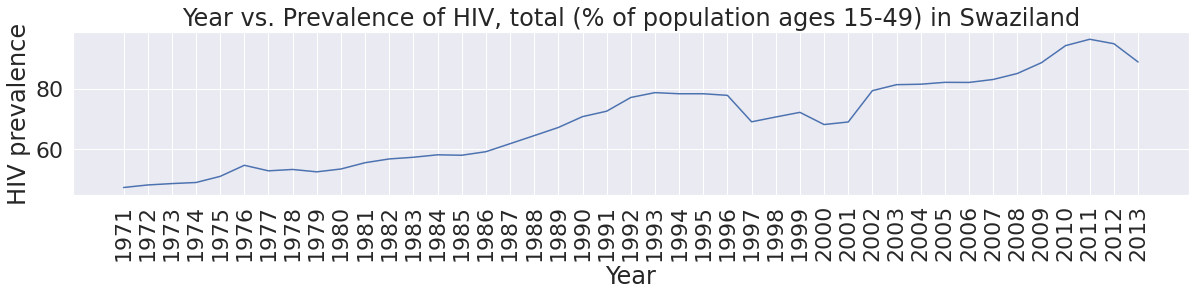

In [ ]:
plt.plot(years_list, rate_list)
plt.xlabel('Year')
plt.ylabel('HIV prevalence')
plt.title('Year vs. Prevalence of HIV, total (% of population ages 15-49) in Swaziland')
plt.xticks(rotation = 90)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

**Analysis:** The Prevalence of HIV tends to increase very fast from 1990 to 1999, and the rate of increase become much slower after 2000. The reason might be that the data for years before 2000 were biased, many people with HIV did not participate in the test. Another reason might be that HIV was widely spread in Swaziland during 1990 and 2000.

### Time series: Prevalence of HIV for female and male.
Next, we take a look at the 'Prevalence of HIV, female (% ages 15-24)', 'Prevalence of HIV, male (% ages 15-24)' factors.

In [ ]:
df_hiv_15_24_female = df_health_population_stats_clean_copy[df_health_population_stats_clean_copy['Indicator'] == 'Prevalence of HIV, female (% ages 15-24)'].reset_index(drop=True)
df_hiv_15_24_female

Country  \
0                                  Arab World   
1                      Caribbean small states   
2    Fragile and conflict affected situations   
3      Heavily indebted poor countries (HIPC)   
4                   Latin America & Caribbean   
..                                        ...   
118                             Venezuela, RB   
119                                   Vietnam   
120                               Yemen, Rep.   
121                                    Zambia   
122                                  Zimbabwe   

                                    Indicator  1960  1961  1962  1963  1964  \
0    Prevalence of HIV, female (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
1    Prevalence of HIV, female (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
2    Prevalence of HIV, female (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
3    Prevalence of HIV, female (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
4    Prevalence of HIV, female (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
..                                        ...   ...   ...   ...   ...   ...   
118  Prevalence of HIV, female (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
119  Prevalence of HIV, female (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
120  Prevalence of HIV, female (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
121  Prevalence of HIV, female (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
122  Prevalence of HIV, female (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   

     1965  1966  1967  ...      2006      2007      2008      2009      2010  \
0     NaN   NaN   NaN  ...  0.126644  0.125232  0.125246  0.124279  0.124768   
1     NaN   NaN   NaN  ...  0.856438  0.795305  0.767417  0.757740  0.697005   
2     NaN   NaN   NaN  ...  0.956969  0.890846  0.835305  0.795685  0.743033   
3     NaN   NaN   NaN  ...  1.571716  1.505308  1.439259  1.401289  1.345358   
4     NaN   NaN   NaN  ...  0.204795  0.196538  0.189307  0.183352  0.176884   
..    ...   ...   ...  ...       ...       ...       ...       ...       ...   
118   NaN   NaN   NaN  ...  0.200000  0.200000  0.200000  0.200000  0.200000   
119   NaN   NaN   NaN  ...  0.300000  0.300000  0.300000  0.300000  0.300000   
120   NaN   NaN   NaN  ...  0.100000  0.100000  0.100000  0.100000  0.100000   
121   NaN   NaN   NaN  ...  6.200000  6.000000  5.800000  5.700000  5.600000   
122   NaN   NaN   NaN  ...  6.800000  6.700000  6.600000  6.700000  6.600000   

         2011      2012      2013      2014      2015  
0    0.125296  0.124379  0.125368  0.125998  0.126628  
1    0.681377  0.664940  0.660886  0.648596  0.655904  
2    0.721102  0.670119  0.654439  0.635828  0.618322  
3    1.304133  1.254428  1.219408  1.173786  1.122074  
4    0.174650  0.174017  0.172223  0.165886  0.164747  
..        ...       ...       ...       ...       ...  
118  0.200000  0.200000  0.200000  0.200000  0.200000  
119  0.300000  0.300000  0.300000  0.200000  0.200000  
120  0.100000  0.100000  0.100000  0.100000  0.100000  
121  5.500000  5.400000  5.300000  5.100000  5.000000  
122  6.500000  6.400000  6.300000  6.100000  5.900000  

[123 rows x 58 columns]

In [ ]:
df_hiv_15_24_male = df_health_population_stats_clean_copy[df_health_population_stats_clean_copy['Indicator'] == 'Prevalence of HIV, male (% ages 15-24)'].reset_index(drop=True)
df_hiv_15_24_male

Country  \
0                                  Arab World   
1                      Caribbean small states   
2    Fragile and conflict affected situations   
3      Heavily indebted poor countries (HIPC)   
4                   Latin America & Caribbean   
..                                        ...   
118                             Venezuela, RB   
119                                   Vietnam   
120                               Yemen, Rep.   
121                                    Zambia   
122                                  Zimbabwe   

                                  Indicator  1960  1961  1962  1963  1964  \
0    Prevalence of HIV, male (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
1    Prevalence of HIV, male (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
2    Prevalence of HIV, male (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
3    Prevalence of HIV, male (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
4    Prevalence of HIV, male (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
..                                      ...   ...   ...   ...   ...   ...   
118  Prevalence of HIV, male (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
119  Prevalence of HIV, male (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
120  Prevalence of HIV, male (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
121  Prevalence of HIV, male (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   
122  Prevalence of HIV, male (% ages 15-24)   NaN   NaN   NaN   NaN   NaN   

     1965  1966  1967  ...      2006      2007      2008      2009      2010  \
0     NaN   NaN   NaN  ...  0.108594  0.106960  0.103561  0.103615  0.103674   
1     NaN   NaN   NaN  ...  0.889835  0.859161  0.790296  0.783595  0.780996   
2     NaN   NaN   NaN  ...  0.571169  0.527829  0.505294  0.483939  0.445371   
3     NaN   NaN   NaN  ...  0.841375  0.816706  0.802607  0.784996  0.760529   
4     NaN   NaN   NaN  ...  0.256811  0.252533  0.246318  0.241552  0.237441   
..    ...   ...   ...  ...       ...       ...       ...       ...       ...   
118   NaN   NaN   NaN  ...  0.300000  0.300000  0.300000  0.300000  0.300000   
119   NaN   NaN   NaN  ...  0.500000  0.400000  0.400000  0.400000  0.400000   
120   NaN   NaN   NaN  ...  0.100000  0.100000  0.100000  0.100000  0.100000   
121   NaN   NaN   NaN  ...  3.400000  3.400000  3.400000  3.300000  3.300000   
122   NaN   NaN   NaN  ...  3.800000  3.800000  3.800000  3.900000  4.000000   

         2011      2012      2013      2014      2015  
0    0.102246  0.102654  0.102681  0.102709  0.102737  
1    0.711695  0.713771  0.715284  0.699437  0.699543  
2    0.438539  0.432497  0.418020  0.413870  0.411421  
3    0.744851  0.735683  0.715870  0.705919  0.676018  
4    0.237516  0.232171  0.224628  0.219081  0.218985  
..        ...       ...       ...       ...       ...  
118  0.300000  0.200000  0.200000  0.200000  0.200000  
119  0.400000  0.300000  0.300000  0.300000  0.300000  
120  0.100000  0.100000  0.100000  0.100000  0.100000  
121  3.300000  3.300000  3.200000  3.200000  3.100000  
122  4.000000  3.900000  3.900000  3.800000  3.800000  

[123 rows x 58 columns]

#### Drop missing values
Simillarly, the table also contains many NaN's on the first many years. We drop all the empty values.

In [ ]:
df_hiv_15_24_female = df_hiv_15_24_female.dropna(axis=1)
df_hiv_15_24_female

Country  \
0                                  Arab World   
1                      Caribbean small states   
2    Fragile and conflict affected situations   
3      Heavily indebted poor countries (HIPC)   
4                   Latin America & Caribbean   
..                                        ...   
118                             Venezuela, RB   
119                                   Vietnam   
120                               Yemen, Rep.   
121                                    Zambia   
122                                  Zimbabwe   

                                    Indicator       1990       1991  \
0    Prevalence of HIV, female (% ages 15-24)   0.102648   0.103046   
1    Prevalence of HIV, female (% ages 15-24)   0.431192   0.612376   
2    Prevalence of HIV, female (% ages 15-24)   1.076199   1.211110   
3    Prevalence of HIV, female (% ages 15-24)   1.892349   2.016578   
4    Prevalence of HIV, female (% ages 15-24)   0.202990   0.218143   
..                                        ...        ...        ...   
118  Prevalence of HIV, female (% ages 15-24)   0.100000   0.100000   
119  Prevalence of HIV, female (% ages 15-24)   0.100000   0.100000   
120  Prevalence of HIV, female (% ages 15-24)   0.100000   0.100000   
121  Prevalence of HIV, female (% ages 15-24)   8.600000   8.800000   
122  Prevalence of HIV, female (% ages 15-24)  11.500000  13.100000   

          1992       1993       1994       1995       1996       1997  ...  \
0     0.105170   0.110891   0.111557   0.113942   0.117940   0.119879  ...   
1     0.729234   0.823440   0.940634   0.984467   1.025546   1.061369  ...   
2     1.341028   1.452910   1.551242   1.629376   1.660248   1.644887  ...   
3     2.103690   2.163284   2.190389   2.220641   2.199325   2.168288  ...   
4     0.227927   0.239128   0.251842   0.255918   0.258654   0.265541  ...   
..         ...        ...        ...        ...        ...        ...  ...   
118   0.100000   0.100000   0.100000   0.100000   0.100000   0.200000  ...   
119   0.100000   0.100000   0.100000   0.100000   0.100000   0.100000  ...   
120   0.100000   0.100000   0.100000   0.100000   0.100000   0.100000  ...   
121   8.900000   8.900000   8.800000   8.700000   8.500000   8.200000  ...   
122  14.500000  15.500000  16.100000  16.300000  15.900000  15.100000  ...   

         2006      2007      2008      2009      2010      2011      2012  \
0    0.126644  0.125232  0.125246  0.124279  0.124768  0.125296  0.124379   
1    0.856438  0.795305  0.767417  0.757740  0.697005  0.681377  0.664940   
2    0.956969  0.890846  0.835305  0.795685  0.743033  0.721102  0.670119   
3    1.571716  1.505308  1.439259  1.401289  1.345358  1.304133  1.254428   
4    0.204795  0.196538  0.189307  0.183352  0.176884  0.174650  0.174017   
..        ...       ...       ...       ...       ...       ...       ...   
118  0.200000  0.200000  0.200000  0.200000  0.200000  0.200000  0.200000   
119  0.300000  0.300000  0.300000  0.300000  0.300000  0.300000  0.300000   
120  0.100000  0.100000  0.100000  0.100000  0.100000  0.100000  0.100000   
121  6.200000  6.000000  5.800000  5.700000  5.600000  5.500000  5.400000   
122  6.800000  6.700000  6.600000  6.700000  6.600000  6.500000  6.400000   

         2013      2014      2015  
0    0.125368  0.125998  0.126628  
1    0.660886  0.648596  0.655904  
2    0.654439  0.635828  0.618322  
3    1.219408  1.173786  1.122074  
4    0.172223  0.165886  0.164747  
..        ...       ...       ...  
118  0.200000  0.200000  0.200000  
119  0.300000  0.200000  0.200000  
120  0.100000  0.100000  0.100000  
121  5.300000  5.100000  5.000000  
122  6.300000  6.100000  5.900000  

[123 rows x 28 columns]

In [ ]:
df_hiv_15_24_male = df_hiv_15_24_male.dropna(axis=1)
df_hiv_15_24_male

Country  \
0                                  Arab World   
1                      Caribbean small states   
2    Fragile and conflict affected situations   
3      Heavily indebted poor countries (HIPC)   
4                   Latin America & Caribbean   
..                                        ...   
118                             Venezuela, RB   
119                                   Vietnam   
120                               Yemen, Rep.   
121                                    Zambia   
122                                  Zimbabwe   

                                  Indicator      1990      1991      1992  \
0    Prevalence of HIV, male (% ages 15-24)  0.101328  0.101718  0.102106   
1    Prevalence of HIV, male (% ages 15-24)  0.701283  0.876473  0.981537   
2    Prevalence of HIV, male (% ages 15-24)  0.645611  0.750635  0.821300   
3    Prevalence of HIV, male (% ages 15-24)  1.114967  1.140149  1.153901   
4    Prevalence of HIV, male (% ages 15-24)  0.287703  0.285972  0.293568   
..                                      ...       ...       ...       ...   
118  Prevalence of HIV, male (% ages 15-24)  0.100000  0.100000  0.100000   
119  Prevalence of HIV, male (% ages 15-24)  0.100000  0.100000  0.100000   
120  Prevalence of HIV, male (% ages 15-24)  0.100000  0.100000  0.100000   
121  Prevalence of HIV, male (% ages 15-24)  4.900000  4.900000  4.800000   
122  Prevalence of HIV, male (% ages 15-24)  7.000000  7.700000  8.400000   

         1993      1994      1995      1996      1997  ...      2006  \
0    0.104212  0.107935  0.109912  0.110194  0.110487  ...  0.108594   
1    1.122915  1.148480  1.168499  1.155363  1.172732  ...  0.889835   
2    0.880990  0.928319  0.966131  0.981120  0.952473  ...  0.571169   
3    1.147429  1.146411  1.134012  1.121566  1.092524  ...  0.841375   
4    0.317897  0.327230  0.302278  0.296587  0.300211  ...  0.256811   
..        ...       ...       ...       ...       ...  ...       ...   
118  0.100000  0.100000  0.200000  0.300000  0.300000  ...  0.300000   
119  0.100000  0.100000  0.100000  0.100000  0.200000  ...  0.500000   
120  0.100000  0.100000  0.100000  0.100000  0.100000  ...  0.100000   
121  4.700000  4.600000  4.500000  4.400000  4.300000  ...  3.400000   
122  8.800000  9.000000  9.000000  8.700000  8.100000  ...  3.800000   

         2007      2008      2009      2010      2011      2012      2013  \
0    0.106960  0.103561  0.103615  0.103674  0.102246  0.102654  0.102681   
1    0.859161  0.790296  0.783595  0.780996  0.711695  0.713771  0.715284   
2    0.527829  0.505294  0.483939  0.445371  0.438539  0.432497  0.418020   
3    0.816706  0.802607  0.784996  0.760529  0.744851  0.735683  0.715870   
4    0.252533  0.246318  0.241552  0.237441  0.237516  0.232171  0.224628   
..        ...       ...       ...       ...       ...       ...       ...   
118  0.300000  0.300000  0.300000  0.300000  0.300000  0.200000  0.200000   
119  0.400000  0.400000  0.400000  0.400000  0.400000  0.300000  0.300000   
120  0.100000  0.100000  0.100000  0.100000  0.100000  0.100000  0.100000   
121  3.400000  3.400000  3.300000  3.300000  3.300000  3.300000  3.200000   
122  3.800000  3.800000  3.900000  4.000000  4.000000  3.900000  3.900000   

         2014      2015  
0    0.102709  0.102737  
1    0.699437  0.699543  
2    0.413870  0.411421  
3    0.705919  0.676018  
4    0.219081  0.218985  
..        ...       ...  
118  0.200000  0.200000  
119  0.300000  0.300000  
120  0.100000  0.100000  
121  3.200000  3.100000  
122  3.800000  3.800000  

[123 rows x 28 columns]

#### Country with highest HIV prevalence for female and male.
Next, we will find the country will the max average value for female and for male.

In [ ]:
df_hiv_15_24_female.mean(axis = 1).idxmax()

107

In [ ]:
df_hiv_15_24_male.mean(axis = 1).idxmax()

107

In [ ]:
df_hiv_15_24_female.iloc[107]

Country                                     Swaziland
Indicator    Prevalence of HIV, female (% ages 15-24)
1990                                              2.6
1991                                              4.7
1992                                              7.6
1993                                             10.9
1994                                             14.3
1995                                             17.4
1996                                             19.7
1997                                             21.3
1998                                             22.1
1999                                             22.3
2000                                             21.9
2001                                             21.3
2002                                             20.4
2003                                             19.5
2004                                             18.7
2005                                             18.1
2006                        

Swaziland has the highest average value of HIV prevalence for both female and male.

Now, we will plot the data for Swaziland from 1990 to 2015 for both female and male.

In [ ]:
df_hiv_15_24_female_numeric = df_hiv_15_24_female[df_hiv_15_24_female['Country'] == 'Swaziland'].drop(columns=['Country', 'Indicator'])
mean_value = float(df_hiv_15_24_female_numeric.mean(axis=1))
df_hiv_15_24_female_numeric = df_hiv_15_24_female_numeric.fillna(mean_value)
years_list = list(df_hiv_15_24_female_numeric)
rate_list = list(df_hiv_15_24_female_numeric.fillna(mean_value).values[0])

df_hiv_15_24_male_numeric = df_hiv_15_24_male[df_hiv_15_24_male['Country'] == 'Swaziland'].drop(columns=['Country', 'Indicator'])
mean_value = float(df_hiv_15_24_male_numeric.mean(axis=1))
df_hiv_15_24_male_numeric = df_hiv_15_24_male_numeric.fillna(mean_value)
years_list1 = list(df_hiv_15_24_male_numeric)
rate_list1 = list(df_hiv_15_24_male_numeric.fillna(mean_value).values[0])

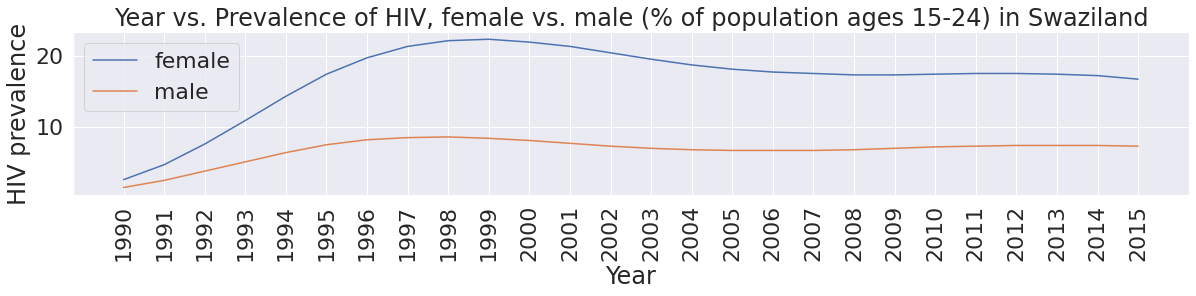

In [ ]:
plt.plot(years_list, rate_list, label='female')
plt.plot(years_list1, rate_list1, label='male')
plt.xlabel('Year')
plt.ylabel('HIV prevalence')
plt.title('Year vs. Prevalence of HIV, female vs. male (% of population ages 15-24) in Swaziland')
plt.xticks(rotation = 90)
plt.rcParams["figure.figsize"] = (20,3)
plt.legend()
plt.show()

**Analysis:** The HIV prevalence of female and male had almost the same pattern in Swaziland. The figure increased from 1990 to 1998, and decreased slightly from 1999 to 2005, finally remained around the same level until 2015. But the HIV prevalence for female is much higher than male. Comparing the data to the HIV prevalence of total population of age 15-49, the figure dropped after 2000, which indicated that the HIV problem is less severe for younger generation after 2000.

### Time series: School enrollment (tertiary)

We take a look at the `School enrollment, tertiary (% gross)` factor, and store the rows with this factor into the `df_school_enrollment_tertiary` dataframe.

In [ ]:
df_school_enrollment_tertiary = df_health_population_stats_clean[df_health_population_stats_clean['Indicator'] == 'School enrollment, tertiary (% gross)']
df_school_enrollment_tertiary.head(5)

Country  \
111                                   Arab World   
230                       Caribbean small states   
334               Central Europe and the Baltics   
545                          East Asia & Pacific   
657  East Asia & Pacific (excluding high income)   

                                 Indicator  1960  1961  1962  1963  1964  \
111  School enrollment, tertiary (% gross)   NaN   NaN   NaN   NaN   NaN   
230  School enrollment, tertiary (% gross)   NaN   NaN   NaN   NaN   NaN   
334  School enrollment, tertiary (% gross)   NaN   NaN   NaN   NaN   NaN   
545  School enrollment, tertiary (% gross)   NaN   NaN   NaN   NaN   NaN   
657  School enrollment, tertiary (% gross)   NaN   NaN   NaN   NaN   NaN   

     1965  1966  1967  ...      2006      2007      2008      2009      2010  \
111   NaN   NaN   NaN  ...  22.16217  22.83028  23.54255  24.22408  24.94406   
230   NaN   NaN   NaN  ...  17.21491  18.45581  19.99009  20.47181  21.84793   
334   NaN   NaN   NaN  ...  59.08792  61.32536  63.99125  65.38102  65.63916   
545   NaN   NaN   NaN  ...  23.36359  23.86508  24.45042  25.91028  27.36372   
657   NaN   NaN   NaN  ...  20.11456  20.73541  21.34799  22.89034  24.35463   

         2011      2012      2013  2014  2015  
111  24.60856  25.98412  27.45988   NaN   NaN  
230  21.69768  23.06213  22.41867   NaN   NaN  
334  64.47030  64.60601  63.77876   NaN   NaN  
545  28.71210  30.87508  33.07254   NaN   NaN  
657  25.60232  27.76401  29.96137   NaN   NaN  

[5 rows x 58 columns]

#### Drop missing values

We found out that many early years did not have a value, so we decide to drop all the missing columns (i.e., years) with more than 30% missing data.

In [ ]:
count = int(0.7 * df_school_enrollment_tertiary.shape[0])
df_school_enrollment_tertiary = df_school_enrollment_tertiary.dropna(axis=1, thresh=count).reset_index(drop=True)
df_school_enrollment_tertiary

Country  \
0                                     Arab World   
1                         Caribbean small states   
2                 Central Europe and the Baltics   
3                            East Asia & Pacific   
4    East Asia & Pacific (excluding high income)   
..                                           ...   
142                               United Kingdom   
143                                United States   
144                                      Uruguay   
145                                Venezuela, RB   
146                                      Vietnam   

                                 Indicator      1971      1972       1973  \
0    School enrollment, tertiary (% gross)   5.82405   6.10911   6.479750   
1    School enrollment, tertiary (% gross)   4.60043   4.85759   5.097720   
2    School enrollment, tertiary (% gross)  12.92129  12.70911  12.923870   
3    School enrollment, tertiary (% gross)   2.87889   2.98934   3.061610   
4    School enrollment, tertiary (% gross)   1.22461   1.26347   1.299550   
..                                     ...       ...       ...        ...   
142  School enrollment, tertiary (% gross)  14.56785  15.44357  16.088430   
143  School enrollment, tertiary (% gross)  47.32349  48.16539  48.623749   
144  School enrollment, tertiary (% gross)       NaN       NaN        NaN   
145  School enrollment, tertiary (% gross)   9.49952  11.13657  12.529350   
146  School enrollment, tertiary (% gross)       NaN       NaN        NaN   

          1974       1975       1976       1977       1978  ...       2004  \
0     6.889330   7.435200   8.089080   8.731930   9.170500  ...  20.613530   
1     5.202860   5.476000   6.143650   6.360640   6.326760  ...  17.572530   
2    13.480650  14.069830  14.832110  15.390390  15.776900  ...  53.383870   
3     3.299420   3.555350   3.801170   3.984890   4.349010  ...  21.647150   
4     1.449080   1.599980   1.734530   1.882580   2.149290  ...  18.110090   
..         ...        ...        ...        ...        ...  ...        ...   
142  16.752411  18.581739  19.208929  19.338270  19.125509  ...  59.363441   
143  48.980202  51.005939  54.668919  52.838711  53.289539  ...  81.463562   
144  12.303080  15.092170        NaN  17.600010        NaN  ...  42.406651   
145  13.554590  15.169580  16.563810        NaN  18.893360  ...  41.550961   
146        NaN        NaN   1.688890   2.018440   2.375290  ...        NaN   

          2005       2006       2007       2008       2009       2010  \
0    21.629010  22.162170  22.830280  23.542550  24.224080  24.944060   
1    17.073890  17.214910  18.455810  19.990090  20.471810  21.847930   
2    56.637470  59.087920  61.325360  63.991250  65.381020  65.639160   
3    22.601960  23.363590  23.865080  24.450420  25.910280  27.363720   
4    19.224880  20.114560  20.735410  21.347990  22.890340  24.354630   
..         ...        ...        ...        ...        ...        ...   
142  59.000992  59.126690  58.652000  56.874008  58.153419  59.066959   
143  82.084442  82.053001  83.031059  85.006821  88.581741  94.228012   
144  45.337212  46.031780  63.729370  64.605240  63.235420  63.133781   
145        NaN        NaN        NaN  77.457352  76.979591        NaN   
146  16.052870  16.670870  18.363640  18.945749  20.109921  22.687679   

          2011       2012       2013  
0    24.608560  25.984120  27.459880  
1    21.697680  23.062130  22.418670  
2    64.470300  64.606010  63.778760  
3    28.712100  30.875080  33.072540  
4    25.602320  27.764010  29.961370  
..         ...        ...        ...  
142  58.985909  59.223141  56.870129  
143  96.322403  94.842278  88.808571  
144        NaN        NaN        NaN  
145        NaN        NaN        NaN  
146  24.802460  25.020920  25.010130  

[147 rows x 45 columns]

#### Max School Enrollment (tertiary)

We want to find the country/ region with the max overall mean school enrollment rate.

In [ ]:
df_school_enrollment_tertiary.mean(axis = 1).idxmax()

143

In [ ]:
df_school_enrollment_tertiary.iloc[143]

Country                              United States
Indicator    School enrollment, tertiary (% gross)
1971                                      47.32349
1972                                      48.16539
1973                                     48.623749
1974                                     48.980202
1975                                     51.005939
1976                                     54.668919
1977                                     52.838711
1978                                     53.289539
1979                                     52.503139
1980                                      53.44659
1981                                      55.52166
1982                                      56.76656
1983                                     57.322071
1984                                     58.132839
1985                                     57.989391
1986                                     59.158562
1987                                      61.80481
1988                           

We could find that the United States is the country which has the maximum average school enrollment rates from 1971 to 2013.

In [ ]:
df_school_enrollment_tertiary_us_numeric = df_school_enrollment_tertiary[df_school_enrollment_tertiary['Country'] == 'United States'].drop(columns=['Country', 'Indicator'])
mean_value = float(df_school_enrollment_tertiary_us_numeric.mean(axis=1))
df_school_enrollment_tertiary_us_numeric = df_school_enrollment_tertiary_us_numeric.fillna(mean_value)
years_list = list(df_school_enrollment_tertiary_us_numeric)
rate_list = list(df_school_enrollment_tertiary_us_numeric.fillna(mean_value).values[0])

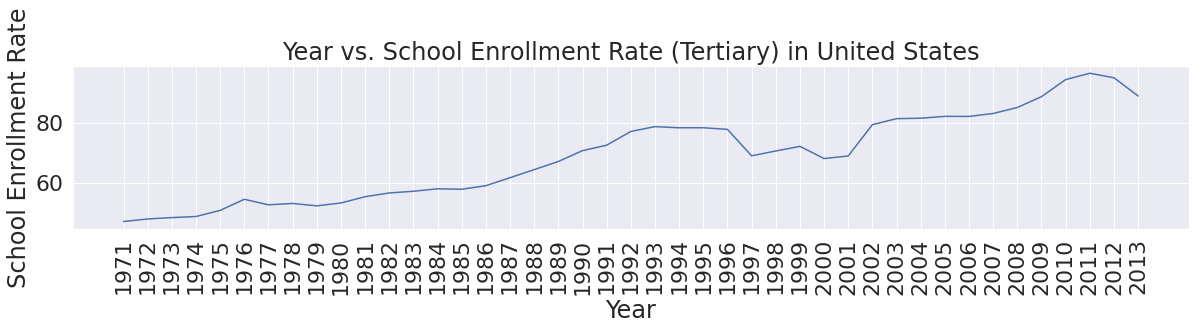

In [ ]:
plt.plot(years_list, rate_list)
plt.xlabel('Year')
plt.ylabel('School Enrollment Rate')
plt.title('Year vs. School Enrollment Rate (Tertiary) in United States')
plt.xticks(rotation = 90)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

**Analysis**: The overall trend of the school enrollment rate in the United States is increasing. There was a lower period from 1997 to 2001, but the enrollment rate is still high. And we can see two rapid increasing period, i.e., 1985 - 1992 and 2007 - 2011.

### World Map for Life expectancy at birth: 1960 vs. 2014

In the previous sections, we plot the world map for average life expectancy at birth and we are shocked about the extremely low value for African countries. In this section, will compare the life expectancy at birth between 1960 and 2014 to find out the trend in this 44 years.

#### World Map for Life expectancy at birth: 1960

We first plot the world plot for year 1960.

In [ ]:
life_expectancy_df = df_health_population_stats_clean[df_health_population_stats_clean['Indicator'] == 'Life expectancy at birth, total (years)']
life_1960_df = life_expectancy_df[['Country', '1960']]
life_1960_df = life_1960_df.rename(columns = {'1960': 'Life expectancy at birth, total (years) in 1960'}).dropna()
life_1960_df

Country  \
37                         Arab World   
156            Caribbean small states   
272    Central Europe and the Baltics   
378        Early-demographic dividend   
480               East Asia & Pacific   
...                               ...   
42682                         Vietnam   
42875           Virgin Islands (U.S.)   
43218                     Yemen, Rep.   
43417                          Zambia   
43629                        Zimbabwe   

       Life expectancy at birth, total (years) in 1960  
37                                           46.850022  
156                                          62.318212  
272                                          67.823762  
378                                          45.147426  
480                                          48.226774  
...                                                ...  
42682                                        59.067024  
42875                                        63.730220  
43218                                        34.363805  
43417                                        45.109805  
43629                                        51.542463  

[230 rows x 2 columns]

The following map may not be able to show up in a local computer, since it is an interactive image. The map can be shown normally on Colab, so please kindly upload this .ipynb file to Colab and view it there if there is an issue viewing the map.

In [ ]:
fig = px.choropleth(data_frame = life_1960_df, locations="Country", locationmode = 'country names',
                    color='Life expectancy at birth, total (years) in 1960', hover_name='Life expectancy at birth, total (years) in 1960',
                    color_continuous_scale=px.colors.sequential.Inferno,
                    title = 'Global Life Expectancy in 1960')

fig.show()

**Analysis:** The plot shows that almost all the country have a lower life expectancy at birth comparing to the average value, indicating a genreral increasing trend at the beginning of the 44 years period. Auatralia, Canada and USA still have the highest value for life expectancy at birth. China on this plot have a extremely low life expectancy at birth value comparing to the average data. Countries in Africa have the lowest values.

#### World Map for Life expectancy at birth: 2014

Then, we plot the world plot for year 2014.

In [ ]:
life_2014_df = life_expectancy_df[['Country', '2014']]
life_2014_df = life_2014_df.rename(columns = {'2014': 'Life expectancy at birth, total (years) in 2014'})

The following map may not be able to show up in a local computer, since it is an interactive image. The map can be shown normally on Colab, so please kindly upload this .ipynb file to Colab and view it there if there is an issue viewing the map.

In [ ]:
fig = px.choropleth(data_frame = life_2014_df, locations="Country", locationmode = 'country names',
                    color='Life expectancy at birth, total (years) in 2014', hover_name='Life expectancy at birth, total (years) in 2014',
                    color_continuous_scale=px.colors.sequential.Inferno,
                    title = 'Global Life Expectancy in 2014')

fig.show()

**Analysis**: Comparing to the plot for 1960, the world generally have a higher life expectancy at birth. Australia, Canada and USA still have the highest value for life expectancy at birth, and the value do not increase much during the 44 years. Countries in Africa still have low life expectancy at birth values after 44 years, the increases is also quite slow. Most of the other countries show the noticeable increase in life expectancy at birthduring the 44 years, and China have the largest increase from 43.35 in 1960 to 75.78 in 2014.

# Model

## Data Processing - 14K+ Training Data Points

In order to obtain a reasonable and valid result from the learning models, we need to ensure that we have enough data to carry out the training.

Our data have more than 40000 rows now, but the indicators are listed as a instance for the rows. We want to move the indicators to the columns, but this will reduce the  number of rows of the data to the number of the countries. The number of countries is less than 300 and the number is too low to perfrom the training. Thus we will move the years from the columns to the rows.

In [ ]:
df_health_population_stats_clean

Country                                          Indicator  \
0      Arab World  Adolescent fertility rate (births per 1,000 wo...   
1      Arab World  Age dependency ratio (% of working-age populat...   
2      Arab World                          Age dependency ratio, old   
3      Arab World                        Age dependency ratio, young   
4      Arab World               Birth rate, crude (per 1,000 people)   
...           ...                                                ...   
43734    Zimbabwe             Survival to age 65, male (% of cohort)   
43735    Zimbabwe                                   Urban population   
43736    Zimbabwe                      Urban population (% of total)   
43737    Zimbabwe                 Urban population growth (annual %)   
43738    Zimbabwe  Women's share of population ages 15+ living wi...   

                1960           1961           1962           1963  \
0         133.555013     134.159119     134.857912     134.504576   
1          87.799235      89.221714      90.502403      91.603014   
2           6.635328       6.746978       6.840980       6.915871   
3          81.024250      82.316142      83.459807      84.413972   
4          47.699716      47.457093      47.199572      46.919206   
...              ...            ...            ...            ...   
43734      43.355800      43.888050      44.420300      44.878710   
43735  473101.000000  497024.000000  524099.000000  562238.000000   
43736      12.608000      12.821000      13.082000      13.578000   
43737       4.897746       4.932942       5.304228       7.024465   
43738            NaN            NaN            NaN            NaN   

                1964           1965           1966           1967  ...  \
0         134.105211     133.569626     132.675635     131.665502  ...   
1          92.414916      92.868163      93.733950      94.100279  ...   
2           6.968155       6.996499       7.065913       7.105005  ...   
3          85.096657      85.470717      86.246560      86.590857  ...   
4          46.611790      46.270750      45.892127      45.483407  ...   
...              ...            ...            ...            ...  ...   
43734      45.337110      45.795520      46.253920      46.712330  ...   
43735  603076.000000  646516.000000  692786.000000  742096.000000  ...   
43736      14.092000      14.620000      15.165000      15.727000  ...   
43737       7.011798       6.955472       6.912320       6.875747  ...   
43738            NaN            NaN            NaN            NaN  ...   

               2006          2007          2008          2009          2010  \
0      5.032914e+01  4.999985e+01  4.988705e+01  4.978121e+01  4.967297e+01   
1      6.578673e+01  6.463007e+01  6.360263e+01  6.273802e+01  6.205350e+01   
2      6.821022e+00  6.765206e+00  6.712015e+00  6.672599e+00  6.653749e+00   
3      5.735923e+01  5.616857e+01  5.512340e+01  5.425597e+01  5.357864e+01   
4      2.727014e+01  2.728815e+01  2.732055e+01  2.737012e+01  2.742164e+01   
...             ...           ...           ...           ...           ...   
43734  2.240553e+01  2.378692e+01  2.722864e+01  3.067035e+01  3.411207e+01   
43735  4.453786e+06  4.487076e+06  4.529077e+06  4.579794e+06  4.638775e+06   
43736  3.392600e+01  3.374300e+01  3.356000e+01  3.337800e+01  3.319600e+01   
43737  5.584083e-01  7.446744e-01  9.316901e-01  1.113585e+00  1.279630e+00   
43738  5.833127e+01  5.858609e+01  5.876080e+01  5.881242e+01  5.882594e+01   

               2011          2012          2013          2014          2015  
0      4.953605e+01  4.938374e+01  4.879656e+01  4.819642e+01           NaN  
1      6.179494e+01  6.168190e+01  6.167869e+01  6.171979e+01  6.175419e+01  
2      6.678820e+00  6.715494e+00  6.767541e+00  6.840458e+00  6.937488e+00  
3      5.331823e+01  5.320907e+01  5.320536e+01  5.322831e+01  5.321811e+01  
4      2.739020e+01  2.728440e+01  2.706754e+01  2.674617e+01           NaN  
...       

We obtain only the numeric values and fill the null data with the mean of the row.

In [ ]:
df_health_population_stats_clean_numeric = df_health_population_stats_clean.drop(columns=['Country', 'Indicator'])
mean_value = df_health_population_stats_clean_numeric.mean(axis=1)
df_health_population_stats_clean_numeric_filled = df_health_population_stats_clean_numeric.T.fillna(mean_value).T
df_health_population_stats_clean_numeric_filled

1960           1961           1962           1963  \
0         133.555013     134.159119     134.857912     134.504576   
1          87.799235      89.221714      90.502403      91.603014   
2           6.635328       6.746978       6.840980       6.915871   
3          81.024250      82.316142      83.459807      84.413972   
4          47.699716      47.457093      47.199572      46.919206   
...              ...            ...            ...            ...   
43734      43.355800      43.888050      44.420300      44.878710   
43735  473101.000000  497024.000000  524099.000000  562238.000000   
43736      12.608000      12.821000      13.082000      13.578000   
43737       4.897746       4.932942       5.304228       7.024465   
43738      57.110083      57.110083      57.110083      57.110083   

                1964           1965           1966           1967  \
0         134.105211     133.569626     132.675635     131.665502   
1          92.414916      92.868163      93.733950      94.100279   
2           6.968155       6.996499       7.065913       7.105005   
3          85.096657      85.470717      86.246560      86.590857   
4          46.611790      46.270750      45.892127      45.483407   
...              ...            ...            ...            ...   
43734      45.337110      45.795520      46.253920      46.712330   
43735  603076.000000  646516.000000  692786.000000  742096.000000   
43736      14.092000      14.620000      15.165000      15.727000   
43737       7.011798       6.955472       6.912320       6.875747   
43738      57.110083      57.110083      57.110083      57.110083   

                1968           1969  ...          2006          2007  \
0         129.190980     126.736756  ...  5.032914e+01  4.999985e+01   
1          94.119929      93.966788  ...  6.578673e+01  6.463007e+01   
2           7.122000       7.126040  ...  6.821022e+00  6.765206e+00   
3          86.630765      86.501888  ...  5.735923e+01  5.616857e+01   
4          45.055133      44.616205  ...  2.727014e+01  2.728815e+01   
...              ...            ...  ...           ...           ...   
43734      47.177470      47.642610  ...  2.240553e+01  2.378692e+01   
43735  794773.000000  850131.000000  ...  4.453786e+06  4.487076e+06   
43736      16.306000      16.880000  ...  3.392600e+01  3.374300e+01   
43737       6.857792       6.733392  ...  5.584083e-01  7.446744e-01   
43738      57.110083      57.110083  ...  5.833127e+01  5.858609e+01   

               2008          2009          2010          2011          2012  \
0      4.988705e+01  4.978121e+01  4.967297e+01  4.953605e+01  4.938374e+01   
1      6.360263e+01  6.273802e+01  6.205350e+01  6.179494e+01  6.168190e+01   
2      6.712015e+00  6.672599e+00  6.653749e+00  6.678820e+00  6.715494e+00   
3      5.512340e+01  5.425597e+01  5.357864e+01  5.331823e+01  5.320907e+01   
4      2.732055e+01  2.737012e+01  2.742164e+01  2.739020e+01  2.728440e+01   
...             ...           ...           ...           ...           ...   
43734  2.722864e+01  3.067035e+01  3.411207e+01  3.755378e+01  4.099550e+01   
43735  4.529077e+06  4.579794e+06  4.638775e+06  4.706484e+06  4.782430e+06   
43736  3.356000e+01  3.337800e+01  3.319600e+01  3.301500e+01  3.283400e+01   
43737  9.316901e-01  1.113585e+00  1.279630e+00  1.449081e+00  1.600765e+00   
43738  5.876080e+01  5.881242e+01  5.882594e+01  5.889931e+01  5.893908e+01   

               2013          2014          2015  
0      4.879656e+01  4.819642e+01  8.497331e+01  
1      6.167869e+01  6.171979e+01  6.175419e+01  
2      6.767541e+00  6.840458e+00  6.937488e+00  
3      5.320536e+01  5.322831e+01  5.321811e+01  
4      2.706754e+01  2.674617e+01  3.655697e+01  
...             ...           ...           ...  
43734  4.401393e+01  4.703236e+01  4.138327e+01  
43735  4.864823e+06  4.955055e+06  5.051547e+06  
43736  3.265400e+01  3.250100e+01  3.237600e+01  
43737  1.708155e+00  1.837793e+00  1.928627e

We add the Country and Indicator back to the dataframe.

In [ ]:
df_health_population_stats_clean_filled = df_health_population_stats_clean_numeric_filled.copy()
df_health_population_stats_clean_filled['Country'] = df_health_population_stats_clean['Country']
df_health_population_stats_clean_filled['Indicator'] = df_health_population_stats_clean['Indicator']
df_health_population_stats_clean_filled

1960           1961           1962           1963  \
0         133.555013     134.159119     134.857912     134.504576   
1          87.799235      89.221714      90.502403      91.603014   
2           6.635328       6.746978       6.840980       6.915871   
3          81.024250      82.316142      83.459807      84.413972   
4          47.699716      47.457093      47.199572      46.919206   
...              ...            ...            ...            ...   
43734      43.355800      43.888050      44.420300      44.878710   
43735  473101.000000  497024.000000  524099.000000  562238.000000   
43736      12.608000      12.821000      13.082000      13.578000   
43737       4.897746       4.932942       5.304228       7.024465   
43738      57.110083      57.110083      57.110083      57.110083   

                1964           1965           1966           1967  \
0         134.105211     133.569626     132.675635     131.665502   
1          92.414916      92.868163      93.733950      94.100279   
2           6.968155       6.996499       7.065913       7.105005   
3          85.096657      85.470717      86.246560      86.590857   
4          46.611790      46.270750      45.892127      45.483407   
...              ...            ...            ...            ...   
43734      45.337110      45.795520      46.253920      46.712330   
43735  603076.000000  646516.000000  692786.000000  742096.000000   
43736      14.092000      14.620000      15.165000      15.727000   
43737       7.011798       6.955472       6.912320       6.875747   
43738      57.110083      57.110083      57.110083      57.110083   

                1968           1969  ...          2008          2009  \
0         129.190980     126.736756  ...  4.988705e+01  4.978121e+01   
1          94.119929      93.966788  ...  6.360263e+01  6.273802e+01   
2           7.122000       7.126040  ...  6.712015e+00  6.672599e+00   
3          86.630765      86.501888  ...  5.512340e+01  5.425597e+01   
4          45.055133      44.616205  ...  2.732055e+01  2.737012e+01   
...              ...            ...  ...           ...           ...   
43734      47.177470      47.642610  ...  2.722864e+01  3.067035e+01   
43735  794773.000000  850131.000000  ...  4.529077e+06  4.579794e+06   
43736      16.306000      16.880000  ...  3.356000e+01  3.337800e+01   
43737       6.857792       6.733392  ...  9.316901e-01  1.113585e+00   
43738      57.110083      57.110083  ...  5.876080e+01  5.881242e+01   

               2010          2011          2012          2013          2014  \
0      4.967297e+01  4.953605e+01  4.938374e+01  4.879656e+01  4.819642e+01   
1      6.205350e+01  6.179494e+01  6.168190e+01  6.167869e+01  6.171979e+01   
2      6.653749e+00  6.678820e+00  6.715494e+00  6.767541e+00  6.840458e+00   
3      5.357864e+01  5.331823e+01  5.320907e+01  5.320536e+01  5.322831e+01   
4      2.742164e+01  2.739020e+01  2.728440e+01  2.706754e+01  2.674617e+01   
...             ...           ...           ...           ...           ...   
43734  3.411207e+01  3.755378e+01  4.099550e+01  4.401393e+01  4.703236e+01   
43735  4.638775e+06  4.706484e+06  4.782430e+06  4.864823e+06  4.955055e+06   
43736  3.319600e+01  3.301500e+01  3.283400e+01  3.265400e+01  3.250100e+01   
43737  1.279630e+00  1.449081e+00  1.600765e+00  1.708155e+00  1.837793e+00   
43738  5.882594e+01  5.889931e+01  5.893908e+01  5.890013e+01  5.882233e+01   

               2015     Country  \
0      8.497331e+01  Arab World   
1      6.175419e+01  Arab World   
2      6.937488e+00  Arab World   
3      5.321811e+01  Arab World   
4      3.655697e+01  Arab World   
...             ...         ...   
43734  4.138327e+01    Zimbabwe   
43735  5.051547e+06    Zimbabwe   
43736  3.237600e+01    Zimbabwe   
43737  1.928627e+00    Zimbabwe   
43738  5.885555e+01    Zimbabwe   

                                               Indicator  
0      Adolescent fertility rate (births per 1,000 wo...  
1    

### Convert years from feature to index

We move the years from the columns to rows. So that each tuple of (country, indicator, year) becomes the index of a unique row of data.

In [ ]:
df_all_health_population_stats = df_health_population_stats_clean_filled.copy()
df_all_health_population_stats = df_all_health_population_stats.melt(id_vars=["Country", "Indicator"], var_name="Year", value_name="Value")
df_all_health_population_stats

Country                                          Indicator  Year  \
0        Arab World  Adolescent fertility rate (births per 1,000 wo...  1960   
1        Arab World  Age dependency ratio (% of working-age populat...  1960   
2        Arab World                          Age dependency ratio, old  1960   
3        Arab World                        Age dependency ratio, young  1960   
4        Arab World               Birth rate, crude (per 1,000 people)  1960   
...             ...                                                ...   ...   
2449379    Zimbabwe             Survival to age 65, male (% of cohort)  2015   
2449380    Zimbabwe                                   Urban population  2015   
2449381    Zimbabwe                      Urban population (% of total)  2015   
2449382    Zimbabwe                 Urban population growth (annual %)  2015   
2449383    Zimbabwe  Women's share of population ages 15+ living wi...  2015   

                Value  
0        1.335550e+02  
1        8.779923e+01  
2        6.635328e+00  
3        8.102425e+01  
4        4.769972e+01  
...               ...  
2449379  4.138327e+01  
2449380  5.051547e+06  
2449381  3.237600e+01  
2449382  1.928627e+00  
2449383  5.885555e+01  

[2449384 rows x 4 columns]

We use a pivot table to move the indicators from rows to columns.

In [ ]:
df_pivot_all_health_population_stats = pd.pivot_table(df_all_health_population_stats, values='Value', index=['Country', 'Year'], columns=['Indicator'], aggfunc=np.sum).reset_index()
df_pivot_all_health_population_stats

Indicator      Country  Year  AIDS estimated deaths (UNAIDS estimates)  \
0          Afghanistan  1960                                     250.0   
1          Afghanistan  1961                                     250.0   
2          Afghanistan  1962                                     250.0   
3          Afghanistan  1963                                     250.0   
4          Afghanistan  1964                                     250.0   
...                ...   ...                                       ...   
14443         Zimbabwe  2011                                   43000.0   
14444         Zimbabwe  2012                                   37000.0   
14445         Zimbabwe  2013                                   35000.0   
14446         Zimbabwe  2014                                   30000.0   
14447         Zimbabwe  2015                                   29000.0   

Indicator  Adolescent fertility rate (births per 1,000 women ages 15-19)  \
0                                                 145.321000               
1                                                 145.321000               
2                                                 145.321000               
3                                                 145.321000               
4                                                 145.321000               
...                                                      ...               
14443                                             114.165800               
14444                                             113.331000               
14445                                             111.866400               
14446                                             110.401800               
14447                                             135.117775               

Indicator  Adults (ages 15+) and children (0-14 years) living with HIV  \
0                                               2.869231e+03             
1                                               2.869231e+03             
2                                               2.869231e+03             
3                                               2.869231e+03             
4                                               2.869231e+03             
...                                                      ...             
14443                                           1.300000e+06             
14444                                           1.300000e+06             
14445                                           1.300000e+06             
14446                                           1.400000e+06             
14447                                           1.400000e+06             

Indicator  Adults (ages 15+) and children (ages 0-14) newly infected with HIV  \
0                                                 611.538462                    
1                                                 611.538462                    
2                                                 611.538462                    
3                                                 611.538462                    
4                                                 611.538462                    
...                                                      ...                    
14443                                           74000.000000                    
14444                                           70000.000000                    
14445                                           69000.000000                    
14446                                           65000.000000                    
14447                                           64000.000000                    

Indicator  Adults (ages 15+) living with HIV  \
0                               2.769231e+03   
1                               2.769231e+03   
2                               2.769231e+03   
3                               2.769231e+03   
4                               2.769231e+03   
...                                      ...   


### Null value imputation

We fill the missing value with the mean of the column.

In [ ]:
df_pivot_all_health_population_stats_final = df_pivot_all_health_population_stats.copy()
df_pivot_all_health_population_stats_final = df_pivot_all_health_population_stats.fillna(df_pivot_all_health_population_stats.mean())
df_pivot_all_health_population_stats_final

Indicator      Country  Year  AIDS estimated deaths (UNAIDS estimates)  \
0          Afghanistan  1960                                     250.0   
1          Afghanistan  1961                                     250.0   
2          Afghanistan  1962                                     250.0   
3          Afghanistan  1963                                     250.0   
4          Afghanistan  1964                                     250.0   
...                ...   ...                                       ...   
14443         Zimbabwe  2011                                   43000.0   
14444         Zimbabwe  2012                                   37000.0   
14445         Zimbabwe  2013                                   35000.0   
14446         Zimbabwe  2014                                   30000.0   
14447         Zimbabwe  2015                                   29000.0   

Indicator  Adolescent fertility rate (births per 1,000 women ages 15-19)  \
0                                                 145.321000               
1                                                 145.321000               
2                                                 145.321000               
3                                                 145.321000               
4                                                 145.321000               
...                                                      ...               
14443                                             114.165800               
14444                                             113.331000               
14445                                             111.866400               
14446                                             110.401800               
14447                                             135.117775               

Indicator  Adults (ages 15+) and children (0-14 years) living with HIV  \
0                                               2.869231e+03             
1                                               2.869231e+03             
2                                               2.869231e+03             
3                                               2.869231e+03             
4                                               2.869231e+03             
...                                                      ...             
14443                                           1.300000e+06             
14444                                           1.300000e+06             
14445                                           1.300000e+06             
14446                                           1.400000e+06             
14447                                           1.400000e+06             

Indicator  Adults (ages 15+) and children (ages 0-14) newly infected with HIV  \
0                                                 611.538462                    
1                                                 611.538462                    
2                                                 611.538462                    
3                                                 611.538462                    
4                                                 611.538462                    
...                                                      ...                    
14443                                           74000.000000                    
14444                                           70000.000000                    
14445                                           69000.000000                    
14446                                           65000.000000                    
14447                                           64000.000000                    

Indicator  Adults (ages 15+) living with HIV  \
0                               2.769231e+03   
1                               2.769231e+03   
2                               2.769231e+03   
3                               2.769231e+03   
4                               2.769231e+03   
...                                      ...   


**Finally, we have more than 14000 rows to train, and 80% of it is still greater than 10k, which aligns with our initial intention of big data.**

## Regression Models

We first fit the linear regression models. We will fit one without any regularizations, one with Lasso regularization, one with Ridge regularization, one with Elastic Net and one using PCA.

### Linear Regression for Predicting Life Expectancy

We want to exam how different facotrs influence the value of life expectrancy at birth. All the relative factors we can think of are included in the list "to_keep".

In [ ]:
life_expectancy = df_pivot_all_health_population_stats_final['Life expectancy at birth, total (years)']

to_keep = ['Immunization, BCG (% of one-year-old children)', 'Immunization, DPT (% of children ages 12-23 months)', \
           'Immunization, measles (% of children ages 12-23 months)', 'Immunization, Pol3 (% of one-year-old children)', \
           'People practicing open defecation (% of population)', 'People practicing open defecation, rural (% of rural population)', \
           'People practicing open defecation, urban (% of urban population)', 'School enrollment, primary (% gross)', \
           'School enrollment, primary (% net)', 'School enrollment, primary, female (% gross)', \
           'School enrollment, primary, male (% gross)', 'School enrollment, secondary (% gross)', \
           'School enrollment, secondary (% net)', 'School enrollment, secondary, female (% gross)', \
           'School enrollment, secondary, female (% net)', 'School enrollment, secondary, male (% gross)', \
           'School enrollment, secondary, male (% net)', 'Improved sanitation facilities, urban (% of urban population with access)', \
           'Improved sanitation facilities (% of population with access)', \
           'Improved sanitation facilities, rural (% of rural population with access)', \
           'Improved sanitation facilities, urban (% of urban population with access)', \
           'Improved water source (% of population with access)', 'Improved water source, rural (% of rural population with access)', \
           'Improved water source, urban (% of urban population with access)']
           
features = df_pivot_all_health_population_stats_final[to_keep]

In [ ]:
# getting the train and test data
x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(features, life_expectancy, test_size = 0.2, random_state = 42)

#### Unregularized Linear Regression

First, we perfrom the unregularized linear regression.

In [ ]:
lin_reg = LinearRegression().fit(x_train_lr, y_train_lr)
y_pred_lr = lin_reg.predict(x_test_lr)

score_lr = r2_score(y_test_lr.values, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_lr))

print(f'The R2 score is {round(score_lr, 5)}.')
print(f'The RMSE score is {round(rmse_lr, 5)}.')

The R2 score is 0.63007.
The RMSE score is 6.56422.


**Analysis**: The R2 score is 0.63007, and RSME is 6.56422. The model presents relatively good predictions.

#### Lasso Regularized Linear Regression

Next, we will use the Lasso Regularized linear regression.

##### Cross Validation

Fit a Lasso model on the training set, with 𝜆 chosen by cross-validation. `LassoCV` automatically picks 100 𝜆 parameters to test and picks the best value. The selected value is named `lasso_select` and we train the corresponding Lasso model, and calculate the R2 score and RMSE value.

In [ ]:
lassocv = LassoCV()
lassocv.fit(x_train_lr, y_train_lr)
lasso_select = lassocv.alpha_

##### Train

In [ ]:
lasso = Lasso(alpha=lasso_select)
lasso.fit(x_train_lr, y_train_lr)
y_pred_lasso = lasso.predict(x_test_lr)

score_lasso = r2_score(y_test_lr.values, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_lasso))

print(f'The R2 score is {round(score_lasso, 5)}.')
print(f'The RMSE score is {round(rmse_lasso, 5)}.')

The R2 score is 0.6296.
The RMSE score is 6.56837.


**Analysis**: The R2 score is 0.6296, and RSME is 6.56837. The model is almost the same with unregularized version.

#### Ridge Regularized Linear Regression

Next, we fit the Ridge Regularized linear regression.

##### Cross Validation

Fit a Ridge regression model on the training set, with 𝜆 chosen by cross-validation. `RidgeCV` performs hyperparameter optimization by testing the provided values for 𝜆 through cross validation. The best 𝜆 value is stored in `ridge_select` and the corresponding Ridge model is trained.

In [ ]:
lambdas = np.linspace(1, 1000, 100)

ridgecv = RidgeCV(alphas=lambdas, scoring='neg_mean_squared_error')
ridgecv.fit(x_train_lr, y_train_lr)
ridge_select = ridgecv.alpha_

##### Train

In [ ]:
ridge = Ridge(alpha=ridge_select)
ridge.fit(x_train_lr, y_train_lr)
y_pred_ridge = ridge.predict(x_test_lr)

score_ridge = r2_score(y_test_lr.values, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_ridge))

print(f'The R2 score is {round(score_ridge, 5)}.')
print(f'The RMSE score is {round(rmse_ridge, 5)}.')

The R2 score is 0.63013.
The RMSE score is 6.56373.


**Analysis**: The R2 score is 0.63013, and RSME is 6.56373. The model is also almost the same with unregularized version.

#### Elastic Net

We fit the linear regression with Elastic Net regularization

##### Cross Validation

Fit a Elastic Net model on the training set, with 𝜆 chosen by cross-validation. `ElasticNetCV` performs hyperparameter optimization by testing the provided values for 𝜆 through cross validation. The best 𝜆 value is stored in `elastic_select` and the corresponding Elastic Net model is trained.

In [ ]:
elasticnetcv = ElasticNetCV(max_iter = 120000)
elasticnetcv.fit(x_train_lr, y_train_lr)
elastic_select = elasticnetcv.alpha_

##### Train

In [ ]:
elastic = ElasticNet(random_state=0, alpha=elastic_select, max_iter = 120000)
elastic.fit(x_train_lr, y_train_lr)
y_pred_elastic = elastic.predict(x_test_lr)

score_elastic = r2_score(y_test_lr.values, y_pred_elastic)
rmse_elastic = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_elastic))

print(f'The R2 score is {round(score_elastic, 5)}.')
print(f'The RMSE score is {round(rmse_elastic, 5)}.')

The R2 score is 0.62951.
The RMSE score is 6.56921.


**Analysis**: The R2 score is 0.62951, and RSME is 6.56921. The model is also almost the same with unregularized version.

#### Linear Regression with PCA

##### Standardize & PCA

Last, we use PCA to reduce the dimension and fit the linear regression.

In [ ]:
scaler = StandardScaler()

x_train_sc_lr = scaler.fit_transform(x_train_lr)
x_test_sc_lr = scaler.transform(x_test_lr)

pca = PCA(n_components = x_train_sc_lr.shape[1])

pca_x_train_lr = pca.fit_transform(x_train_sc_lr)

Let's plot the number of compents vs the cumulative explained variance.

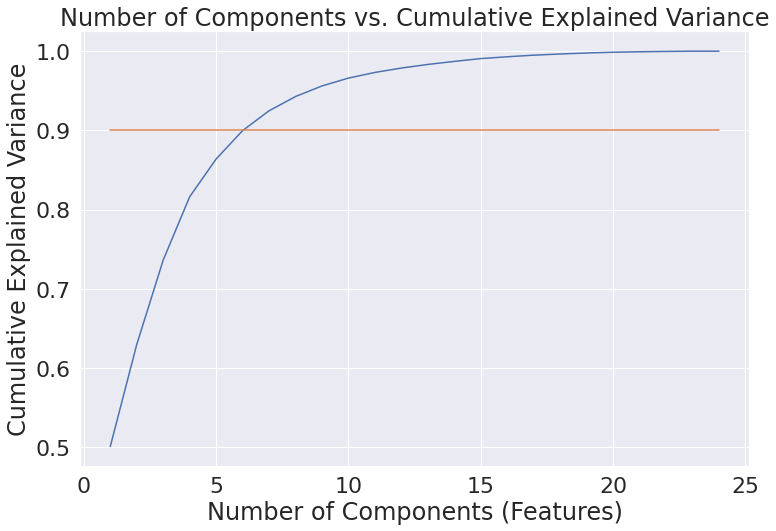

We first surpass 90% explained variance with 7 components.


In [ ]:
cum_expl_var_ratios_lr = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(cum_expl_var_ratios_lr)+1), cum_expl_var_ratios_lr)
plt.plot(np.arange(1, len(cum_expl_var_ratios_lr)+1), [0.90]*len(cum_expl_var_ratios_lr))
plt.xlabel("Number of Components (Features)")
plt.ylabel("Cumulative Explained Variance")
plt.title("Number of Components vs. Cumulative Explained Variance")
plt.show()

for i in range(len(cum_expl_var_ratios_lr)):
  if cum_expl_var_ratios_lr[i] >= 0.90:
    print("We first surpass 90% explained variance with " + str(i + 1) + " components.")
    break

We found that 7 principle components are good enough to cover more than 90% of the variance in the dataset, i.e., a cumulative explained variance of more than 90%. Hence, we will use 7 principle components to proceed with our model.

In [ ]:
pca_lr = PCA(n_components = 7)

pca_x_train_sc_lr = pca_lr.fit_transform(x_train_sc_lr)

# The x train/test set with only the ideal 7 components
pca_x_test_sc_lr = pca_lr.transform(x_test_sc_lr)

In [ ]:
lin_reg_pca = LinearRegression().fit(pca_x_train_sc_lr, y_train_lr)
y_pred_pca_lr = lin_reg_pca.predict(pca_x_test_sc_lr)

score_pca_lr = r2_score(y_test_lr.values, y_pred_pca_lr)
rmse_pca_lr = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_pca_lr))

print(f'The R2 score is {round(score_pca_lr, 5)}.')
print(f'The RMSE score is {round(rmse_pca_lr, 5)}.')

The R2 score is 0.60976.
The RMSE score is 6.742.


**Analysis**: The R2 score is 0.60976, and RSME is 6.742. The model is worse than the previous 4 models.

## Classification Models

Although it is definitely useful to use regression models for the prediction of life expectancy, it is also great to divide the life expectancy into binary groups, i.e., high vs low, and perform analysis on the dataset. Therefore, now we can convert the question into a classification one.

### Use The Median Life Expetancy to Define Classes

To use a classification model, we need to define a categorical data. We first take a look at the life expectancy data and the median value.

In [ ]:
life_expectancy

0        32.328512
1        32.777439
2        33.219902
3        33.657878
4        34.092878
           ...    
14443    51.600366
14444    53.643073
14445    55.633000
14446    57.498317
14447    53.010113
Name: Life expectancy at birth, total (years), Length: 14448, dtype: float64

In [ ]:
life_expectancy.median()

64.39628048780486

We define two categories, where 1 indicating the life expectancy is higher than the median value of life expectancy and 0 indicating the life expectancy is lower than the median value of life expectancy

In [ ]:
def get_life_expectancy(x):
  if x > life_expectancy.median():
    return 1
  else:
    return 0

In [ ]:
life_expectancy_labels = life_expectancy.apply(lambda x: get_life_expectancy(x))
life_expectancy_labels

0        0
1        0
2        0
3        0
4        0
        ..
14443    0
14444    0
14445    0
14446    0
14447    0
Name: Life expectancy at birth, total (years), Length: 14448, dtype: int64

### Logistic Regression

We first fit a logistic regression model. We standarized the data before training.

In [ ]:
scaler = StandardScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)

In [ ]:
x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(features_scaled, life_expectancy_labels, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x_train_log, y_train_log)
predict = clf.predict(x_test_log)
predict

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_log, predict)

0.8252595155709342

**Analysis** : The test accuracy is 0.825, which is not very high but acceptable, the model does a fairly good job on predicting the labels for life expectancy.

### Neural Networks

Next, we fit a feed-forward neural network model.

In [ ]:
scaler = StandardScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)

In [ ]:
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(features_scaled, life_expectancy_labels, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), random_state=1, max_iter = 120000)
clf.fit(x_train_nn, y_train_nn)
predict = clf.predict(x_test_nn)
predict

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
accuracy_score(y_test_nn, predict)

0.8567474048442907

**Analysis** : The test accuracy is 0.857, which is slightly higher than the logistic regression model. The neural network model does a better good job on predicting the labels for life expectancy than the logistic regression model.

### Decision Tree

We then move to decision tree model, which is another classic model for classification.

In [ ]:
x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(features, life_expectancy_labels, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(x_train_dt, y_train_dt)
predict = clf.predict(x_test_dt)
predict

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
accuracy_score(y_test_dt, predict)

0.9297577854671281

The test accuracy is 0.930, which is pretty high. The model does a much better job on predicting the labels for life expectancy than logistic regression model and neural network model.

### Random Forest

After seeing the good result from the decision tree model, we move to random forest model, and looking forward for a even better result.

In [ ]:
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(features, life_expectancy_labels, test_size = 0.2, random_state = 42)

#### Parameter Tuning

We first iterate the max depth from 1 through 50 and plot the test accuracy to get the best max depth.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

best_acc = 0.0
best_clf_depth = 1
acc_list = []

for curr_max_depth in range(1, 51):
  clf = RandomForestClassifier(max_depth = curr_max_depth)
  clf.fit(x_train_rf, y_train_rf)
  predict = clf.predict(x_test_rf)
  curr_acc = accuracy_score(y_test_rf, predict)
  acc_list.append(curr_acc)
  if curr_acc > best_acc:
    best_acc = curr_acc
    best_clf_depth = curr_max_depth
  print(f'Current max depth of the random forest is : {curr_max_depth}, the accuracy is : {curr_acc}.')

print('-----------------------------------------')
print(f'The best random forest model has the max depth of {best_clf_depth} with accuracy {best_acc}.')

Current max depth of the random forest is : 1, the accuracy is : 0.7837370242214533.
Current max depth of the random forest is : 2, the accuracy is : 0.8363321799307959.
Current max depth of the random forest is : 3, the accuracy is : 0.8366782006920416.
Current max depth of the random forest is : 4, the accuracy is : 0.8411764705882353.
Current max depth of the random forest is : 5, the accuracy is : 0.8543252595155709.
Current max depth of the random forest is : 6, the accuracy is : 0.884083044982699.
Current max depth of the random forest is : 7, the accuracy is : 0.9013840830449827.
Current max depth of the random forest is : 8, the accuracy is : 0.916955017301038.
Current max depth of the random forest is : 9, the accuracy is : 0.9297577854671281.
Current max depth of the random forest is : 10, the accuracy is : 0.9380622837370243.
Current max depth of the random forest is : 11, the accuracy is : 0.9380622837370243.
Current max depth of the random forest is : 12, the accuracy is :

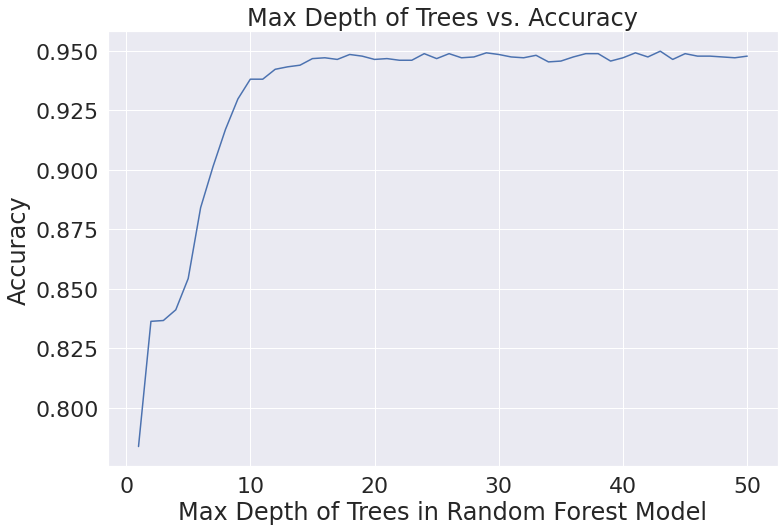

In [ ]:
depth_range = list(range(1, 51))

plt.figure(figsize=(12, 8))
plt.plot(depth_range, acc_list)
plt.xlabel("Max Depth of Trees in Random Forest Model")
plt.ylabel("Accuracy")
plt.title("Max Depth of Trees vs. Accuracy")
plt.show()

(There may be some randomness in the training, so the value may vary a bit.)

**Analysis**: From the result above, we can see that the best random forest model has the max depth of more than 25. From the plot, we can see that the accuracy, in general, increases as the max depth of trees increases. However, the increasing rate soon reduces to nearly 0 when the max depth of trees reaches 12. **To avoid overfitting, we should choose the relatively simple model, which is the random forest model with max depth of 12.**

## Novel Model - ARIMA Time Series + Regression Prediction

The **outline** of our novel ARIMA time series + regression model is:

1. Iterate through all of the 24 features we use for the linear regression model one by one.

2. For each feature, we create a time series for that feature by taking the mean for that feature across all countries/ regions.

3. Drop the null values in the time series.

4. Utilize the auto ARIMA to find the best ARIMA model for each time series.

5. Predict the future values of the features using the ARIMA model.

6. Fit the predicted features into the trained linear regression model, and get the predicted life expectancy.


In [ ]:
from pmdarima.arima import auto_arima

features = ['Immunization, BCG (% of one-year-old children)', 'Immunization, DPT (% of children ages 12-23 months)', \
           'Immunization, measles (% of children ages 12-23 months)', 'Immunization, Pol3 (% of one-year-old children)', \
           'People practicing open defecation (% of population)', 'People practicing open defecation, rural (% of rural population)', \
           'People practicing open defecation, urban (% of urban population)', 'School enrollment, primary (% gross)', \
           'School enrollment, primary (% net)', 'School enrollment, primary, female (% gross)', \
           'School enrollment, primary, male (% gross)', 'School enrollment, secondary (% gross)', \
           'School enrollment, secondary (% net)', 'School enrollment, secondary, female (% gross)', \
           'School enrollment, secondary, female (% net)', 'School enrollment, secondary, male (% gross)', \
           'School enrollment, secondary, male (% net)', 'Improved sanitation facilities, urban (% of urban population with access)', \
           'Improved sanitation facilities (% of population with access)', \
           'Improved sanitation facilities, rural (% of rural population with access)', \
           'Improved sanitation facilities, urban (% of urban population with access)', \
           'Improved water source (% of population with access)', 'Improved water source, rural (% of rural population with access)', \
           'Improved water source, urban (% of urban population with access)']

predicted_feature_dict = {}

for feature in features:
  ts = df_health_population_stats_clean[df_health_population_stats_clean['Indicator'] == feature].drop(columns=['Country', 'Indicator']).mean()
  ts = ts.dropna()
  model = auto_arima(ts, trace=True, error_action='ignore', suppress_warnings=True)
  model.fit(ts)
  for year in range(2016, 2051):
    if year not in predicted_feature_dict:
      predicted_feature_dict[year] = []
    predicted_feature_dict[year].append(model.predict(n_periods=50)[str(year) + '-01-01'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=151.723, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=146.479, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=148.994, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=156.677, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=146.243, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=148.132, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=148.215, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=147.174, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=148.316, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=144.748, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=145.465, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=146.561, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=146.696, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=145.714, 

### Prediected Life Expectancy for 2016 - 2050

Now let's fit the predicted model into the trained linear regression model.

Since Ridge linear regression has the best R2 score, we will use ridge linear regression model to finish our predictions.

In [ ]:
predicted_life_expectancy = {}

In [ ]:
for year in range(2016, 2051):
  prediction = float(ridge.predict(np.array([predicted_feature_dict[year]])))
  predicted_life_expectancy[year] = prediction

In [ ]:
predicted_life_expectancy

{2016: 69.26850447619528,
 2017: 68.23123157549543,
 2018: 68.54510534187139,
 2019: 69.00456913477673,
 2020: 69.25732212577824,
 2021: 69.64221022197589,
 2022: 69.99998985517078,
 2023: 70.34190893498737,
 2024: 70.71046369786964,
 2025: 71.07264163193068,
 2026: 71.43055975041524,
 2027: 71.80346433667842,
 2028: 72.1657835719212,
 2029: 72.53512822753382,
 2030: 72.90658164799454,
 2031: 73.27328681258615,
 2032: 73.6470692626716,
 2033: 74.0176508748446,
 2034: 74.38868642848561,
 2035: 74.76337502168778,
 2036: 75.13424118224424,
 2037: 75.50841629291104,
 2038: 75.88232145346541,
 2039: 76.25476902691182,
 2040: 76.6301048080337,
 2041: 77.00343056300977,
 2042: 77.37760582148653,
 2043: 77.75274471147578,
 2044: 78.1263017460248,
 2045: 78.50149654839547,
 2046: 78.87608293070217,
 2047: 79.25037544971994,
 2048: 79.62574570731859,
 2049: 80.00008985492671,
 2050: 80.37505193301676}

In [ ]:
life_expectancy_df = df_health_population_stats_clean[df_health_population_stats_clean['Indicator'] == 'Life expectancy at birth, total (years)']
life_expectancy_clean_df = life_expectancy_df.drop(columns = ['Country', 'Indicator'])
real_life_expectancy = life_expectancy_clean_df.mean()

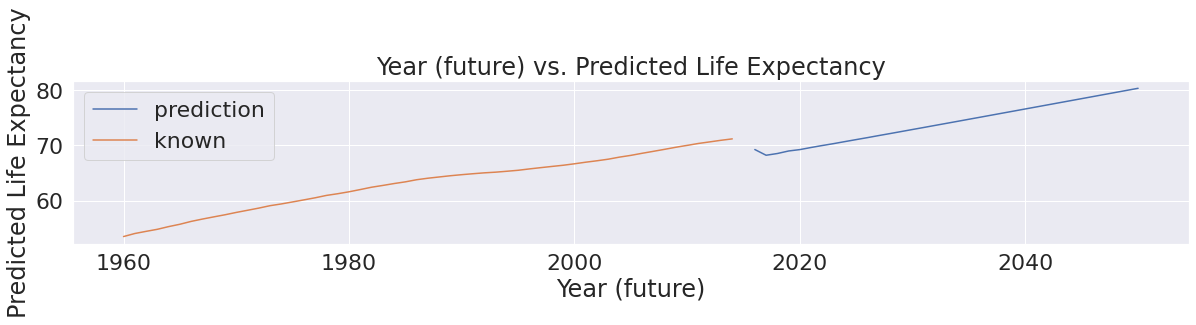

In [ ]:
lists = predicted_life_expectancy.items()
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y, label='prediction')
plt.plot(list(range(1960, 2016)), real_life_expectancy, label='known')
plt.xlabel('Year (future)')
plt.ylabel('Predicted Life Expectancy')
plt.title('Year (future) vs. Predicted Life Expectancy')
plt.rcParams["figure.figsize"] = (10,3)
plt.legend()
plt.show()

**Analysis**: We can see that the predicted life expectancy around the world is higher as the time goes on into the future, which is as what we have expected and quite align with the real trend shown from 1960 to 2015. However, there is a small drop between the last known value with the first predicted value, which may be due to that our models are not robust enough to capture all information and structure of the datase. This is also a modest outlier in the year of 2017, which decreases a bit.

# Conclusion

## Regression Models

We have fitted five different linear regression models, i.e., the vanilla, LASSO (L1), Ridge (L2), Elastic Net (L1 + L2), and PCA. From the results shown in the model chapter, we can not find significance differences in the R2 scores and the RMSE values. Therefore, we can say that, using the cross validation, we can find a relatively good fit for all five models. And the influence of scale or regularization is limited for our dataset when using the linear regressions.

## Classification Models

We trained logistic regression, neural network, decision tree and random forest in our analysis above. The logistic regression and the neural network have test accuracy around 0.85, this is not a high score, but still acceptable. The decision tree and random forest have accuracy scores at around 0.95, which is quite impressive. Before the training, we do not forecast the accuracy score of the decision tree to be that high, because the decision tree is very likely to overfit. But it tends out the decision tree is highly reliable and this may be due to the fact that the values of some features are strongly related to life expectancy at birth. We can easily draw a separation line to distinguish the classes of life expectancy at birth.

## Novel ARIMA + Regression Prediction

From the last plot shown in the predicted life expectancy section, we can see that our model can successfully capture the trend and slope with the dataset to derive a reasonal prediction into the future. Therefore, we can say that the time series for the features in the current dataset can be well explained by the ARIMA model, and our ridge linear regression model is robust enough to convert the selected 24 features into the predicted life expectancy.

There should be some improvement space to address the gap between 2015 data and 2016 prediction, and we can try to work further on it when we found more suitable models.

# Discussion

According to the World Health Organization(WHO), “lifespans are getting longer…life expectancy has increased by more than 6 years between 2000 and 2019 – from 66.8 years in 2000 to 73.4 years in 2019,” which align with our analysis[1]. Interestingly, the report states that the healthy life expectancy (HALE), which is determined by “number of years a person is expected to live in good health,[2]” showing a 5.4 year increase, has not kept up with the increase in life expectancy which increased by 6.6 years. As the HALE index differs from life expectancy in mainly mortality and burden of disease, the above inconsistency implies that communicable disease programmes, such as HIV, tuberculosis, and malaria still need attention. 

In a more general scenario, influencing factors of life expectancy includes genetics, lifestyle choices, and access to healthcare.

At the same time, a chronic failure to acknowledge the central role of primary health care, and to adequately fund key elements such as the health workforce, both slowed the effectiveness of the response to COVID-19 and triggered disruptions to routine care which threaten to further jeopardize countries’ abilities to reach the 2030 Sustainable Development Goals for health.


Some of the most important factors that can influence life expectancy include:

1. Genetics: Genetics play a significant role in determining a person's lifespan. People who have a family history of diseases like heart disease and cancer may have a shorter lifespan than those who don't.
2. Lifestyle choices: A person's lifestyle choices can also have a big impact on their life expectancy. Smoking, excessive alcohol consumption, poor diet, and lack of exercise can all increase the risk of serious health conditions and reduce life expectancy.
3. Access to healthcare: A person's access to quality healthcare can also have a big impact on their life expectancy. People who live in areas with good healthcare systems and access to medical treatment are more likely to live longer than those who don't have access to such services.
4. Environmental factors: The environment in which a person lives can also affect their life expectancy. Exposure to pollutants and other harmful substances can increase the risk of certain health conditions and reduce life expectancy.
5. Socioeconomic factors: Socioeconomic factors like education, income, and social support can also influence life expectancy. People who are better educated and have higher incomes and greater social support tend to live longer than those who don't.





Works Cited:

[1]World Health Organization. (n.d.). Ghe: Life expectancy and healthy life expectancy. World Health Organization. Retrieved December 12, 2022, from https://www.who.int/data/gho/data/themes/mortality-and-global-health-estimates/ghe-life-expectancy-and-healthy-life-expectancy 

[2]World Health Organization. (n.d.). Indicator metadata registry details. World Health Organization. Retrieved December 12, 2022, from https://www.who.int/data/gho/indicator-metadata-registry/imr-details/66 


# Potential Next Steps

We already fit many models in our analysis, however, there are still many points we can consider in the future.


First, we noticed that there are many missing values in the dataframe, we use both the K nearest neighbors method and filling with the mean value from all the existing feature values. Nevertheless, the disputed data is extremely likely to be biased. We can look up the data on the internet and fill it with the value on the internet.


Second, our data present in a time series format naturally, but we only used the ARIMA model in our analysis. In the future, we can try more time series methods to make predictions about the future trend.


Next, we could use more machine learning models. In the classification problems, we receive a not high score for logistic regression and neural network, we could try more classification models that may give better predictions.


Last but not least, we only focused on the life expectancy at birth in our analysis. There are more than 300 indicators in our data, we could try to fit more models based on other indicators. 
